In [110]:
import pandas as pd
import numpy as np
import pyperclip as pc
import requests
import kaggle

# ________________________________________
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup

# ____________________________________________________________________
from scipy import stats
from statsmodels.stats import proportion
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import chart_studio.plotly as py
import cufflinks as cf
import datetime as dt

#_____________________________________________________________________
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

from joblib import Parallel, delayed
import multiprocessing
from IPython.display import display, clear_output
import plotly.tools as tls
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

#___________________________________________________________________
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
cf.go_offline()

# tls.set_credentials_file(username='marcelofprado', api_key='cftsFWfYZ7DgpGQtDuRe')
# init_notebook_mode(connected=True)

np.seterr(divide='ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [142]:
def conf_int(count, nobs, alpha = 0.05, method = 'binom_test'):
    try:
        a = proportion.proportion_confint(count = count, nobs = nobs, alpha = alpha, method = method)
    except ValueError:
        a = [0, 0]
    return a

resp = pd.read_csv('resp.csv')
resp.columns = ['state', 'equipments']
resp_sum = resp['equipments'].sum()
resp = resp.set_index('state', drop = True)

hh = 18
str_today = (dt.date.today() - dt.timedelta(hours=hh)).strftime('%Y-%m-%d')
str_cases = (dt.date.today() - dt.timedelta(days=13)).strftime('%Y-%m-%d')

state_dict = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AP': 'Amapá',
    'AM': 'Amazonas',
    'BA': 'Bahia',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MT': 'Mato Grosso',
    'MS': 'Mato Grosso do Sul',
    'MG': 'Minas Gerais',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PR': 'Paraná',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'RJ': 'Rio de Janeiro',
    'RN': 'Rio Grande do Norte',
    'RS': 'Rio Grande do Sul',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'SC': 'Santa Catarina',
    'SP': 'São Paulo',
    'SE': 'Sergipe',
    'TO': 'Tocantins'
}

region_dict = {
    'AC': 'N',
    'AL': 'NE',
    'AP': 'N',
    'AM': 'N',
    'BA': 'NE',
    'CE': 'NE',
    'DF': 'CO',
    'ES': 'SE',
    'GO': 'CO',
    'MA': 'NE',
    'MT': 'CO',
    'MS': 'CO',
    'MG': 'SE',
    'PA': 'N',
    'PB': 'NE',
    'PR': 'S',
    'PE': 'NE',
    'PI': 'NE',
    'RJ': 'SE',
    'RN': 'NE',
    'RS': 'S',
    'RO': 'N',
    'RR': 'N',
    'SC': 'S',
    'SP': 'SE',
    'SE': 'NE',
    'TO': 'N'
}

char_dict = {
    'Á': 'A',
    'É': 'E',
    'Í': 'I',
    'Ó': 'O',
    'Ú': 'U',
    'Ã': 'A',
    'Õ': 'O',
    'Ç': 'C',
    'Â': 'A',
    'Ê': 'E',
    'Ô': 'O'
}

inv_state_dict = {v: k for k, v in state_dict.items()}

In [143]:
url = 'https://pt.wikipedia.org/wiki/Estat%C3%ADsticas_da_pandemia_de_COVID-19_no_Brasil'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

In [179]:
table = soup.find_all('table')[2]
rows = table.find_all('tr')
header = table.find_all('th')

result = []
h = []
for item in header:
    h.append(item.get_text().replace('\n',''))

for row in rows:
    items = row.find_all('td')
    a = []
    for item in items:
        cont = item.get_text().replace('\n','')
        a.append(cont)
    result.append(a)
    
    
df_result = pd.DataFrame(result)
df_result.columns = h
df_result['date'] = str_today
df_result = df_result.loc[1:]
df_result['Unidade federativa'] = df_result['Unidade federativa'].str.replace('  ', ' ')
# print(h)
df_result.to_csv('./scrapping/' + str_today + '_city_cases.csv')
df_result.columns = ['city', 'UF', 'cases', 'population', 'cases_per_million', 'date']
df_result['state'] = df_result['UF'].replace(inv_state_dict)
df_result['city'] = df_result['city'].str.upper()
df_result['cases'] = df_result['cases'].str.replace('\xa0','').astype(float)

for old, new in char_dict.items():
    df_result['city'] = df_result['city'].str.replace(old,new)
    
print(len(df_result))
# df_result

692


In [265]:
df_rm = pd.read_csv('municipalities_RM.csv', dtype={'city_ibge_code': object, 'COD_MUN': object, 'COD': object})
df_beds_rm = pd.read_csv('beds_rm.csv', dtype={'ibge_code': object})
df_beds_rm.columns = ['cod', 'name', 'uf', 'beds', 'beds_sus', 'beds_non_sus']
df_beds_rm['id'] = df_beds_rm['cod'].str[:4]
df_beds_rm = df_beds_rm.groupby('id').sum()
df_rm = df_rm[['NOME', 'COD', 'TIPO', 'COD_MUN', 'NOME_MUN']]
df_rm.columns = ['name', 'id', 'type', 'ibge_code', 'city']

url = 'https://data.brasil.io/dataset/covid19/caso-full.csv.gz'
# file = requests.get(url)
df_cities = pd.read_csv(url, dtype={'city_ibge_code': object})
df_cities = df_cities[df_cities['place_type'] == 'city'][['city', 'date', 'city_ibge_code', 'last_available_confirmed', 'last_available_deaths']].fillna(0)
df_cities.columns = ['city', 'date','ibge_code', 'cases', 'deaths']
df_rm = df_cities.merge(df_rm, on = ['ibge_code'], how='outer').dropna(subset = ['name'])
df_rm = df_rm.merge(df_beds_rm, on = ['id'], how = 'outer')
df_rm.to_csv('20200408_beds_RM_brazil.csv')

city_x        date ibge_code  cases  deaths  \
0          Anadia  2020-02-26   2700201  0.000   0.000   
1          Anadia  2020-02-27   2700201  0.000   0.000   
2          Anadia  2020-02-28   2700201  0.000   0.000   
3          Anadia  2020-02-29   2700201  0.000   0.000   
4          Anadia  2020-03-01   2700201  0.000   0.000   
...           ...         ...       ...    ...     ...   
61271  Tocantínia  2020-04-05   1721109  0.000   0.000   
61272  Tocantínia  2020-04-06   1721109  0.000   0.000   
61273  Tocantínia  2020-04-07   1721109  0.000   0.000   
61274  Tocantínia  2020-04-08   1721109  0.000   0.000   
61275         NaN         NaN       NaN    nan     nan   

                                          name    id type      city_y  \
0      Região Metropolitana do Vale do Paraíba  2703   RM      ANADIA   
1      Região Metropolitana do Vale do Paraíba  2703   RM      ANADIA   
2      Região Metropolitana do Vale do Paraíba  2703   RM      ANADIA   
3      Região Metropolitana do Vale do Paraíba  2703   RM      ANADIA   
4      Região Metropolitana do Vale do Paraíba  2703   RM      ANADIA   
...                                        ...   ...  ...         ...   
61271           Região Metropolitana de Palmas  1701   RM  TOCANTÍNIA   
61272           Região Metropolitana de Palmas  1701   RM  TOCANTÍNIA   
61273           Região Metropolitana de Palmas  1701   RM  TOCANTÍNIA   
61274           Região Metropolitana de Palmas  1701   RM  TOCANTÍNIA   
61275                                      NaN  4303  NaN         NaN   

          beds  beds_sus  
0      202.000   202.000  
1      202.000   202.000  
2      202.000   202.000  
3      202.000   202.000  
4      202.000   202.000  
...        ...       ...  
61271 1378.000   908.000  
61272 1378.000   908.000  
61273 1378.000   908.000  
61274 1378.000   908.000  
61275 1938.000   983.000  

[61276 rows x 11 columns]

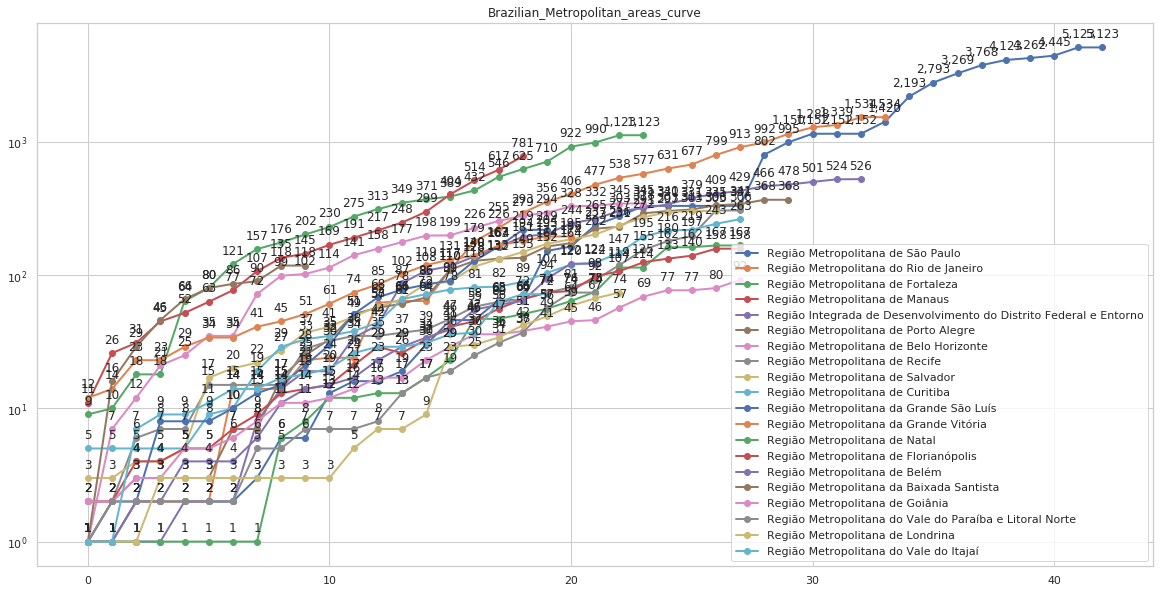

In [269]:
pt_df_rm = df_rm.pivot_table(values = 'cases', index = 'name', columns = 'date', aggfunc = 'sum')
pt_df_rm = pt_df_rm.sort_values(by = str_today, ascending = False)

df = pd.DataFrame()
for i in pt_df_rm.head(20).iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))
plt.yscale('log')

# plt.rc('font', **font)
title = 'Brazilian_Metropolitan_areas_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

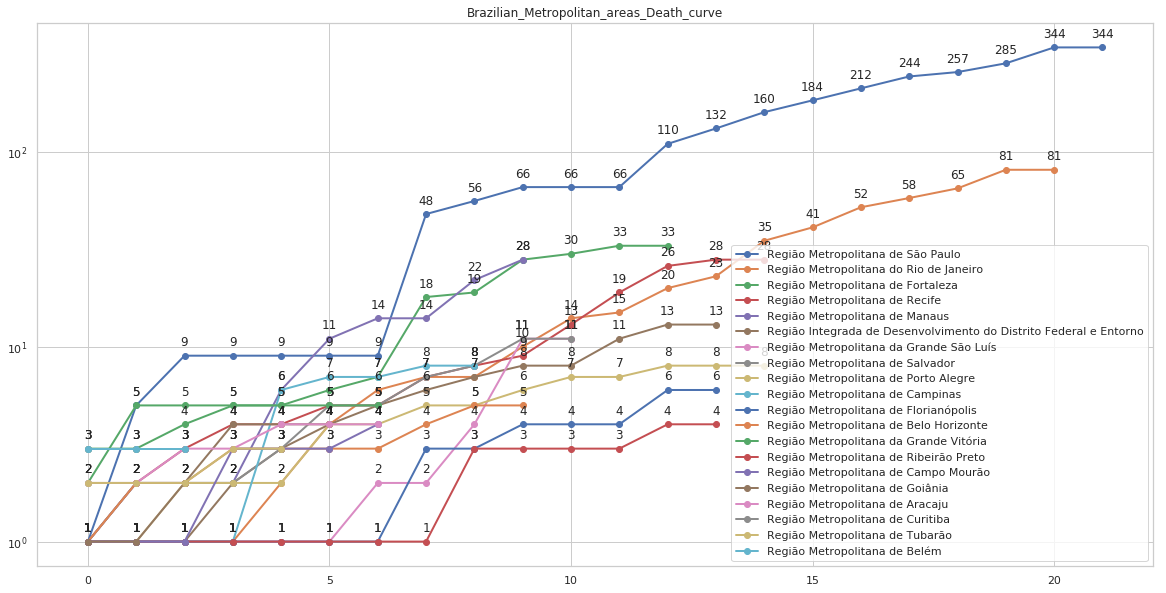

In [268]:
pt_df_rm = df_rm.pivot_table(values = 'deaths', index = 'name', columns = 'date', aggfunc = 'sum')
pt_df_rm = pt_df_rm.sort_values(by = str_today, ascending = False)

df = pd.DataFrame()
for i in pt_df_rm.head(20).iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))
plt.yscale('log')

# plt.rc('font', **font)
title = 'Brazilian_Metropolitan_areas_Death_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

In [145]:
df_cities_biz = pd.read_csv('20200402_cities_biz.csv')
df_cities_biz['region'] = df_cities_biz['state'].replace(region_dict)
df_cities_biz = df_cities_biz.dropna()
df_biz_cases = df_cities_biz.merge(df_result[['cases', 'city', 'state']], on = ['city', 'state'], how = 'left').fillna(0)
df_biz_cases['flag_cases'] = (df_biz_cases['cases'] > 0)
pt_biz = df_biz_cases.pivot_table(values = 'cases', index = 'region', columns = 'flag_cases', aggfunc = 'count')
pt_biz.loc['Brasil'] = pt_biz.sum()
df_result_all = pt_biz.div(pt_biz.sum(axis = 1), axis = 0) * 100
df_result_all['avg_cases'] = df_biz_cases.groupby('region').mean()['cases']
gp_df_cities_biz = df_cities_biz.groupby('region').sum()
gp_df_cities_biz.loc['Brasil'] = gp_df_cities_biz.sum()
gp_df_cities_biz_div = gp_df_cities_biz.div(gp_df_cities_biz.sum(axis = 1), axis = 0) * 100
df_result_all = df_result_all.merge(gp_df_cities_biz_div, on = 'region')
# df_result.sort_values(by = True, ascending = False)
df_result_all

False   True  avg_cases  comercio  industria  servicos  agro  \
region                                                                 
CO     71.074 28.926      6.174    43.620      7.715    43.175 0.445   
N      70.103 29.897      9.454    60.181      4.977    29.638 0.679   
NE     71.935 28.065      7.197    45.135      8.378    40.450 0.270   
S      49.778 50.222      5.876    41.294     11.703    40.913 0.761   
SE     57.773 42.227     16.160    39.218      7.409    48.644 0.252   
Brasil 62.331 37.669        nan    42.472      8.141    44.100 0.388   

        construcao  
region              
CO           5.045  
N            4.525  
NE           5.766  
S            5.328  
SE           4.477  
Brasil       4.900

In [238]:
url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-' + str_today + '.xlsx'
# file = requests.get(url)
world_data = pd.read_excel(url)
world_data.columns = ['date', 'day', 'month', 'year', 'cases', 'deaths', 'country', 'country_geoid', 'country_code', 'population']
print(str_cases + " - " + str_today)
# world_data.head(5)

2020-03-26 - 2020-04-08


In [239]:
pt_world_data = world_data.pivot_table(values = 'cases', index = 'country', columns = 'date', aggfunc = sum)
pt_world_death = world_data.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc = sum).cumsum(axis = 1)
pt_world_daily = pt_world_data.copy()
pt_world_data = pt_world_data.cumsum(axis = 1)
pt_world_data = pt_world_data[pt_world_data[str_today] > 1000].sort_values(by=str_today, ascending = False)

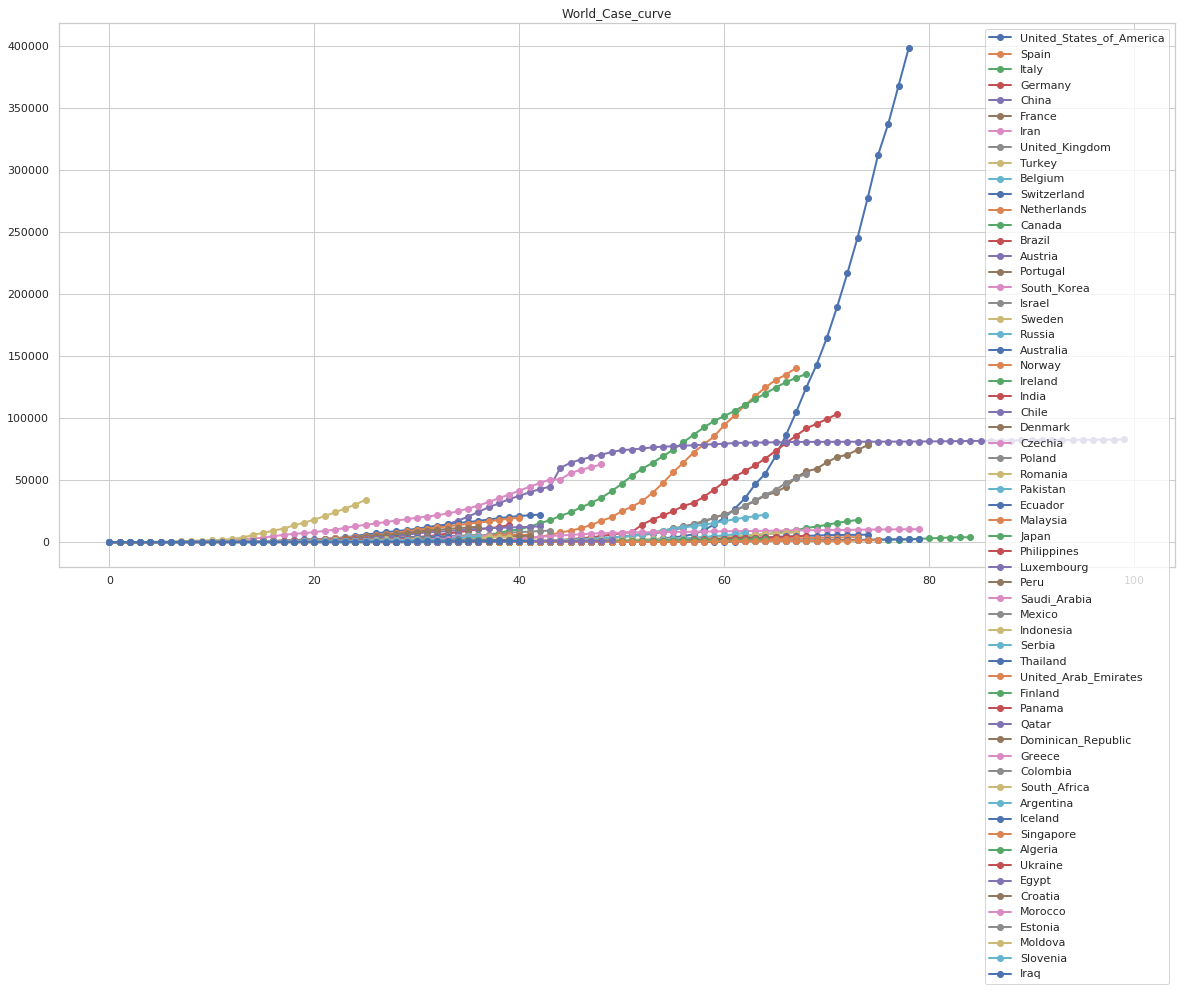

In [240]:
df = pd.DataFrame()
for i in pt_world_data.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
plt.figure(figsize = (20,10))
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}

plt.rc('font', **font)
title = 'World_Case_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

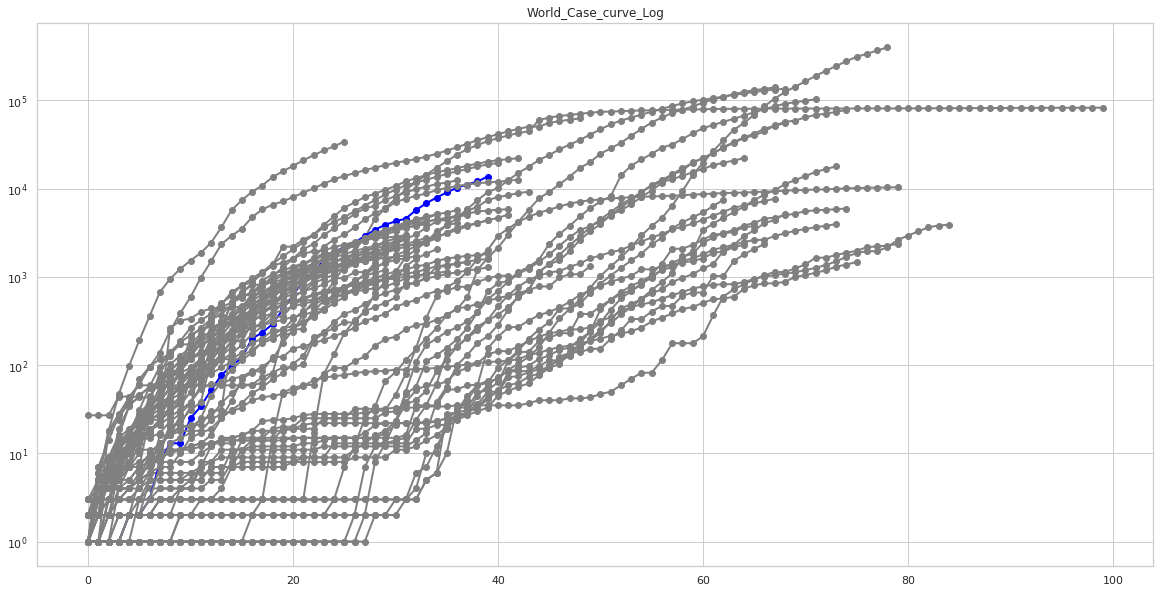

In [149]:
df = pd.DataFrame()
for i in pt_world_data.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
plt.yscale('log')
title = 'World_Case_curve_Log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o', color = ('blue' if (i[1].name =='Brazil') else 'gray'))
#     plt.legend()
    
plt.savefig('./img/' + title)

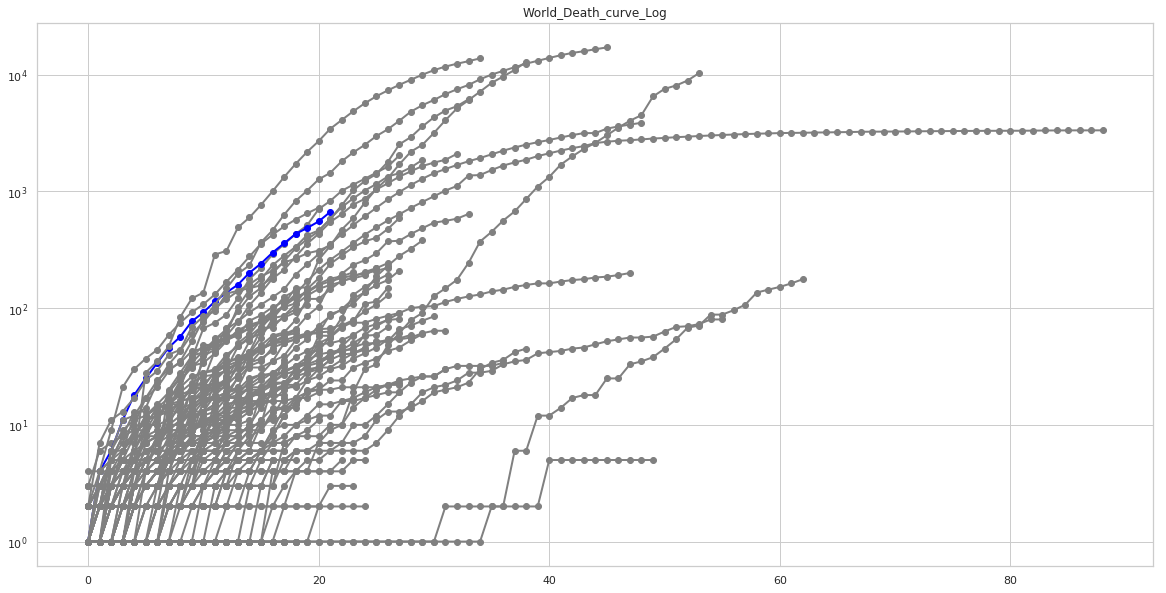

In [150]:
df = pd.DataFrame()
for i in pt_world_death.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
plt.yscale('log')
title = 'World_Death_curve_Log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o', color = ('blue' if (i[1].name =='Brazil') else 'gray'))
#     plt.legend()
    
plt.savefig('./img/' + title)

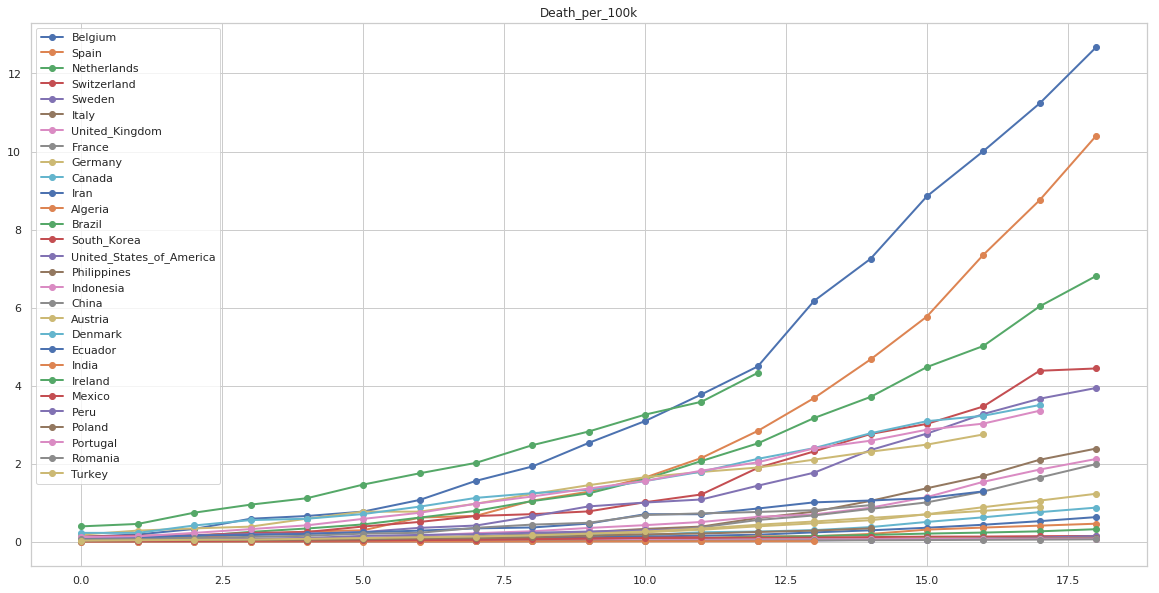

In [151]:
pt_world_data_deaths = world_data.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc = sum).cumsum(axis = 1)
pt_world_data_deaths = pt_world_data_deaths[pt_world_data_deaths[str_today] > 100]
pt_world_data_pop = world_data.pivot_table(values = 'population', index = 'country', columns = 'date', aggfunc = sum)
pt_world_data_pop = pt_world_data_pop[pt_world_data_pop[str_today] > 1000000]
pt_data = pt_world_data_deaths
pt_data = pt_data[~pt_data[str_today].isna()].sort_values(by=str_today, ascending = False)
df = pd.DataFrame()
for i in pt_data.iterrows():
    temp = i[1]
    temp = temp.loc[temp >= 10].reset_index(drop = True)
    df = df.append(temp)

df = (df.div(pt_world_data_pop[str_today], axis = 0) * 100000)
df = df[~df[0].isna()]
df = df[df.loc[['Brazil']].dropna(axis = 1).columns]
df = df.sort_values(by = len(df.columns) -1, ascending = False)
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
# plt.yscale('log')
title = 'Death_per_100k'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)



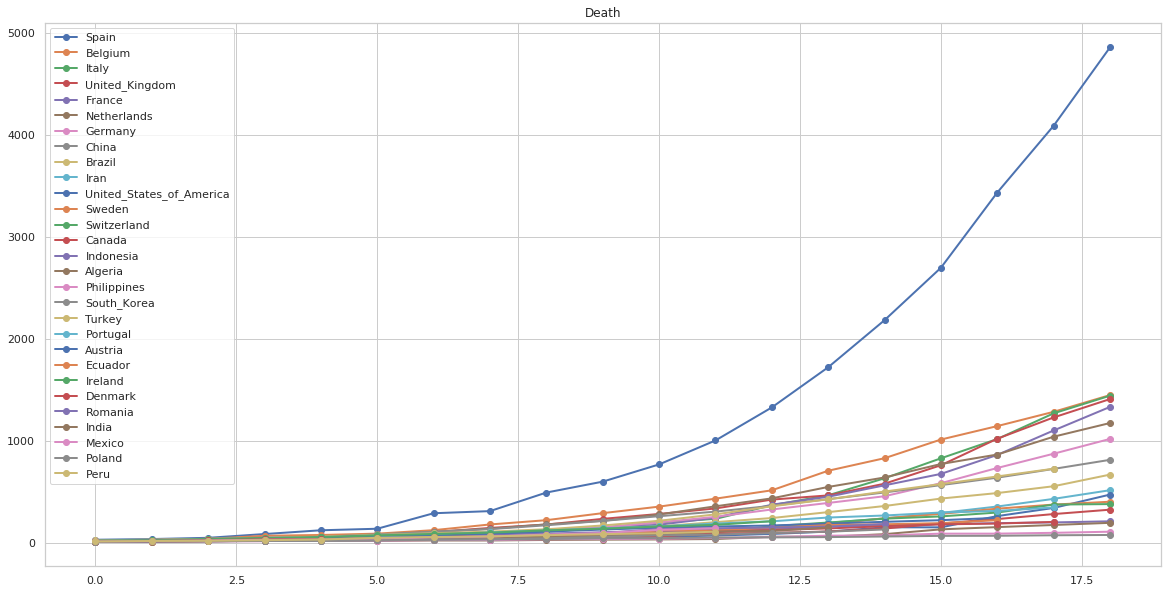

In [152]:
pt_world_data_deaths = world_data.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc = sum).cumsum(axis = 1)
pt_world_data_deaths = pt_world_data_deaths[pt_world_data_deaths[str_today] > 100]
pt_world_data_pop = world_data.pivot_table(values = 'population', index = 'country', columns = 'date', aggfunc = sum)
pt_world_data_pop = pt_world_data_pop[pt_world_data_pop[str_today] > 1000000]
pt_data = pt_world_data_deaths
pt_data = pt_data[~pt_data[str_today].isna()].sort_values(by=str_today, ascending = False)
df = pd.DataFrame()
for i in pt_data.iterrows():
    temp = i[1]
    temp = temp.loc[temp >= 10].reset_index(drop = True)
    df = df.append(temp)

# df = (df.div(pt_world_data_pop[str_today], axis = 0) * 100000)
df = df[~df[0].isna()]
df = df[df.loc[['Brazil']].dropna(axis = 1).columns]
df = df.sort_values(by = len(df.columns) -1, ascending = False)
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
# plt.yscale('log')
title = 'Death'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)



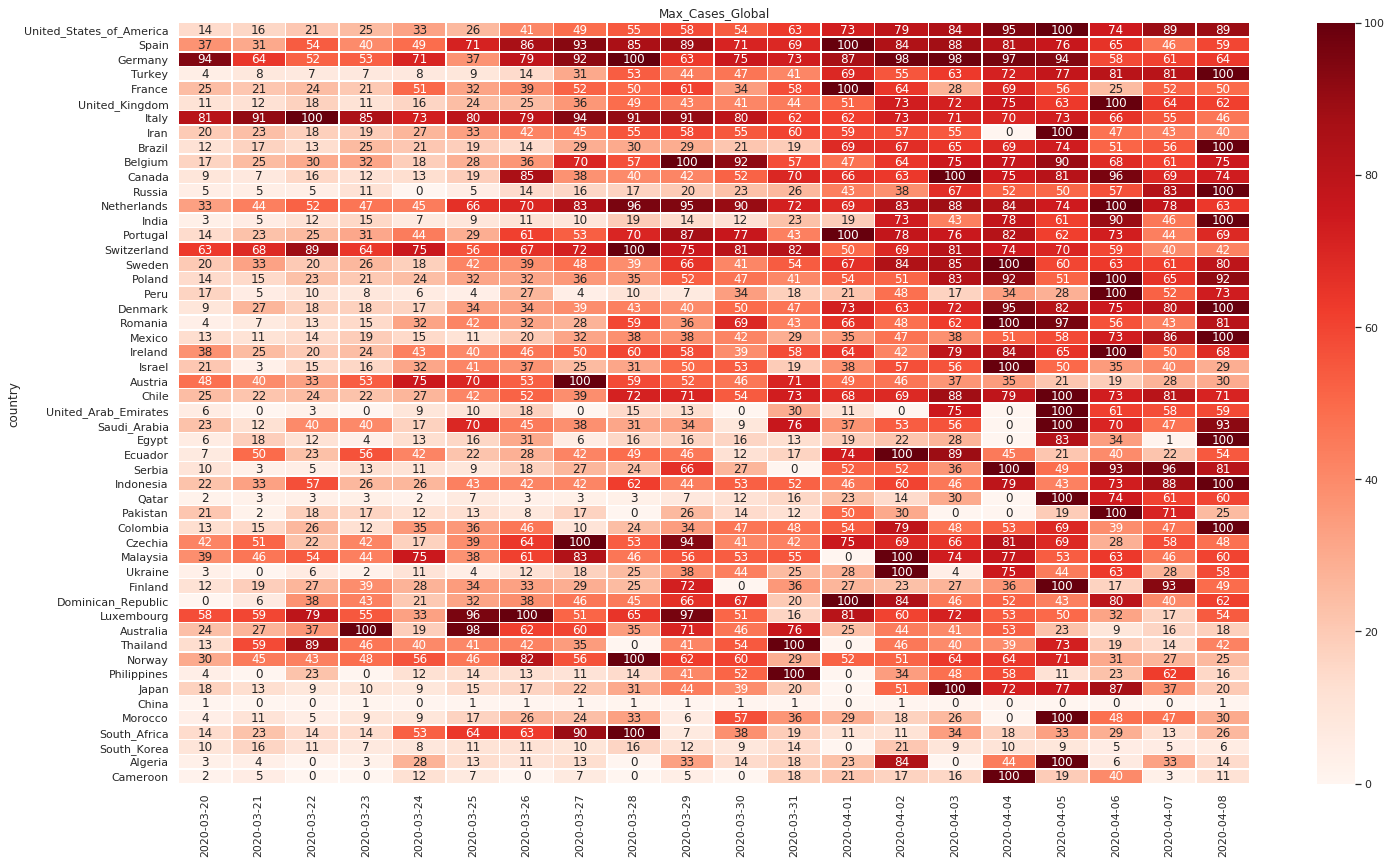

In [153]:
plt.figure(figsize = (24,14))
title = 'Max_Cases_Global'
max_cases = pt_world_daily.max(axis = 1)
df_aux = pt_world_daily[max_cases > 200]
df_aux = df_aux.sort_values(by=str_today, ascending = False)
df_aux.columns = df_aux.columns.date
df_result = df_aux.div(df_aux.max(axis = 1), axis = 0) * 100
df_result = df_result[df_result.columns[-20:]]
plt.title(title)
sns.heatmap(df_result, annot = True, linewidths = 0.5, cmap='Reds', fmt=',.0f')
plt.savefig('./img/' + title)
# df_aux

s:  0.8446004309005914
s_star:  2.3270478123838654


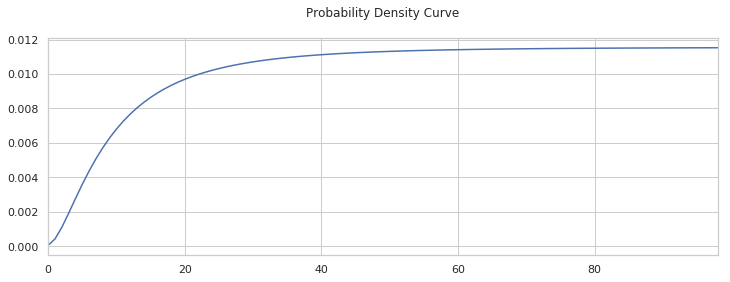

In [154]:
zmeanHDT = 13
zsdHDT = 12.7
zmedianHDT = 9.1
muHDT = np.log(zmedianHDT)
sigmaHDT = np.sqrt(2*(np.log(zmeanHDT/zmedianHDT)))
s = sigmaHDT
cCFRBaseline = 1.38
cCFREstimateRange = [1.23, 1.53]
cCFRIQRRange = [1.3, 1.4]

print('s: ',sigmaHDT)
print('s_star: ',np.exp(sigmaHDT))
# print('mu: ', muHDT)

# Hospitalisation to death distribution
def HDT(x):
    dist = stats.lognorm(s = sigmaHDT, scale = zmedianHDT)
    a = dist.cdf(x)
    return a
    

x = list(range(1,100))
p_curve = pd.Series([HDT(i) for i in x])
p_curve = p_curve / p_curve.sum()

plt.figure(figsize=(12,4))
plt.title('Probability Density Curve\n')
p_curve.plot()


In [155]:
n = 60
death_est = (2.0, 2.5, 3.0)

# print(world_data)
df = pd.DataFrame()
def loop_cases_analysis(i = 0):
    str_today = (dt.date.today() - dt.timedelta(hours=hh) - dt.timedelta(days=i)).strftime('%Y-%m-%d')
    print(str_today)
    world_data['rel_date'] = (dt.datetime.now() - dt.timedelta(days = i) - pd.to_datetime(world_data['date'])).dt.days
    world_data['known'] = HDT(world_data['rel_date'])
    world_data['known_cases'] = world_data['known'] * world_data['cases']
    wd_known_cases = world_data.pivot_table(values = 'known_cases', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
    wd_deaths = world_data.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
    wd_cases = world_data.pivot_table(values = 'cases', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
    wd_death_rate = (wd_deaths / wd_known_cases * 100).fillna(0)
    wd_death_rate = wd_death_rate[wd_death_rate[str_today] > 0]
    wd_reported = (death_est[1] / wd_death_rate * 100).replace(np.inf, np.nan)
    # wd_reported = wd_reported[wd_reported.columns[-4:]].sort_values(by = str_today, ascending = False)
    wd_reported = wd_reported.sort_values(by = str_today, ascending = False)
    # wd_reported.loc[['Germany', 'United_States_of_America', 'Italy','China']]
    # print(wd_known_cases)
    wd_curr = pd.DataFrame(wd_known_cases[str_today])
    wd_curr['cases'] = wd_cases[str_today]
    wd_curr['deaths'] = wd_deaths[str_today]
    wd_curr.columns = ['known', 'cases', 'deaths']
    wd_curr.loc['world'] = wd_curr.sum()
#     wd_curr = wd_curr[wd_curr['deaths'] > 5].sort_values(by='deaths')
    wd_copy = wd_curr.copy()
    wd_copy['not_known'] = (wd_curr['cases'] - wd_curr['known']) / wd_curr['cases']
    wd_copy['known'] = ( wd_curr['known']) / wd_curr['cases']
    wd_copy['total_cases'] = (wd_copy['deaths'] / wd_copy['known']) / (death_est[1] / 100)
    # wd_copy.sort_values(by = 'total_cases', ascending = False)[['total_cases']]
    wd_curr['quantile25'] = [conf_int(count = wd_curr.loc[i]['deaths'], nobs = wd_curr.loc[i]['known'], method = 'binom_test')[0] for i in wd_curr.index]
    wd_curr['quantile75'] = [conf_int(count = wd_curr.loc[i]['deaths'], nobs = wd_curr.loc[i]['known'], method = 'binom_test')[1] for i in wd_curr.index]
    wd_curr['average'] = wd_curr['deaths'] / wd_curr['known']
    wd_curr['death_est_avg'] = 2.5
    try:
        wd_curr.loc['Brazil']['death_est_avg'] = 1.1
        wd_curr.loc['Italy']['death_est_avg'] = 3.1
        wd_curr.loc['United_States_of_America']['death_est_avg'] = 2.0
        wd_curr.loc['Germany']['death_est_avg'] = 2.5
    except KeyError:
        pass
    wd_curr['quantile25_rep'] = (death_est[0] / wd_curr['quantile25']).replace(np.inf, np.nan)
    wd_curr['quantile75_rep'] = (death_est[2] / wd_curr['quantile75']).replace(np.inf, np.nan)
    wd_curr['average_rep'] = (wd_curr['death_est_avg'] / wd_curr['average']).replace(np.inf, np.nan)
    wd_curr = wd_curr[wd_curr['deaths'] >= 1].sort_values(by='average_rep', ascending = False)
    result = wd_curr['average_rep']
    result.name = str_today
    return result

num_cores = multiprocessing.cpu_count()
b_results = Parallel(n_jobs = num_cores, verbose = 5)(delayed(loop_cases_analysis)(i = x) for x in range(0,n))    

# proportion.proportion_confint(count = br_curr.loc['Brasil']['deaths'], nobs = br_curr.loc['Brasil']['known'], method = 'binom_test')
# br_curr.loc[0]['deaths']
df = pd.DataFrame(b_results)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   58.0s
[Parallel(n_jobs=8)]: Done  58 out of  60 | elapsed:  2.7min remaining:    5.6s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:  2.7min finished


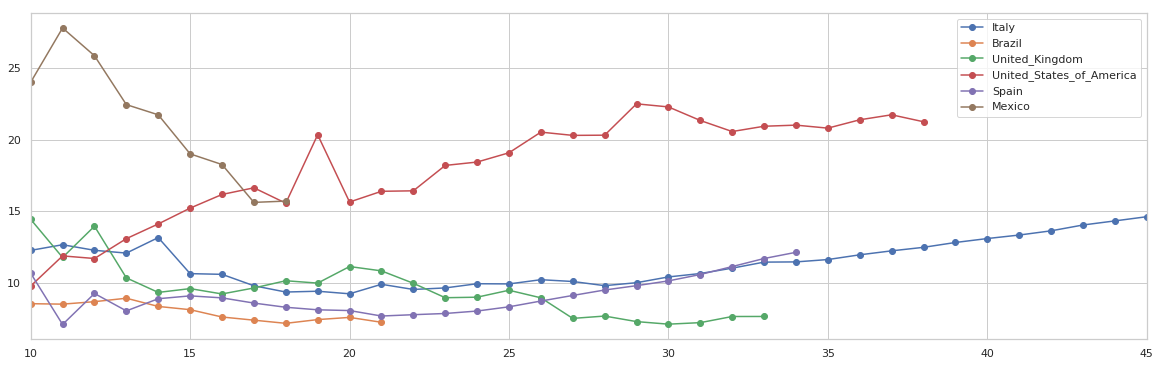

In [156]:
# df.loc[['Brazil']].T.sort_index()
# df.loc[['South_Korea']].T.sort_index()
df_2 = df[['Italy','Brazil', 'United_Kingdom', 'United_States_of_America', 'Spain', 'Mexico' ]]
df_adj = pd.DataFrame()
for a in df_2.columns:
    temp = df[a].dropna().sort_index().reset_index(drop = True)
    df_adj[temp.name] = temp

df_adj.loc[df_adj.index >= 10].plot(figsize = (20,6), marker = 'o')
# df_2['Brazil']

In [157]:
str_today = (dt.date.today() - dt.timedelta(hours=hh)).strftime('%Y-%m-%d')
print(str_today)
world_data['rel_date'] = (dt.datetime.now() - pd.to_datetime(world_data['date'])).dt.days
world_data['known'] = HDT(world_data['rel_date'])
world_data['known_cases'] = world_data['known'] * world_data['cases']
wd_known_cases = world_data.pivot_table(values = 'known_cases', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
wd_deaths = world_data.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
wd_cases = world_data.pivot_table(values = 'cases', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
wd_death_rate = (wd_deaths / wd_known_cases * 100).fillna(0)
wd_death_rate = wd_death_rate[wd_death_rate[str_today] > 0]
wd_reported = (death_est[1] / wd_death_rate * 100).replace(np.inf, np.nan)
# wd_reported = wd_reported[wd_reported.columns[-4:]].sort_values(by = str_today, ascending = False)
wd_reported = wd_reported.sort_values(by = str_today, ascending = False)
# wd_reported.loc[['Germany', 'United_States_of_America', 'Italy','China']]
# print(wd_known_cases)
wd_curr = pd.DataFrame(wd_known_cases[str_today])
wd_curr['cases'] = wd_cases[str_today]
wd_curr['deaths'] = wd_deaths[str_today]
wd_curr.columns = ['known', 'cases', 'deaths']
wd_curr.loc['world'] = wd_curr.sum()
wd_curr = wd_curr[wd_curr['deaths'] > 50].sort_values(by='deaths')
wd_copy = wd_curr.copy()
wd_copy['not_known'] = (wd_curr['cases'] - wd_curr['known']) / wd_curr['cases']
wd_copy['known'] = ( wd_curr['known']) / wd_curr['cases']
wd_copy['total_cases'] = (wd_copy['deaths'] / wd_copy['known']) / (death_est[1] / 100)
# wd_copy.sort_values(by = 'total_cases', ascending = False)[['total_cases']]
wd_curr['quantile25'] = [conf_int(count = wd_curr.loc[i]['deaths'], nobs = wd_curr.loc[i]['known'], method = 'binom_test')[0] for i in wd_curr.index]
wd_curr['quantile75'] = [conf_int(count = wd_curr.loc[i]['deaths'], nobs = wd_curr.loc[i]['known'], method = 'binom_test')[1] for i in wd_curr.index]
wd_curr['average'] = wd_curr['deaths'] / wd_curr['known']
wd_curr['death_est_avg'] = 2.5
try:
    wd_curr.loc['Brazil']['death_est_avg'] = 1.1
    wd_curr.loc['Italy']['death_est_avg'] = 3.1
    wd_curr.loc['United_States_of_America']['death_est_avg'] = 2.0
    wd_curr.loc['Germany']['death_est_avg'] = 2.5
except KeyError:
    pass
wd_curr['quantile25_rep'] = (death_est[0] / wd_curr['quantile25']).replace(np.inf, np.nan)
wd_curr['quantile75_rep'] = (death_est[2] / wd_curr['quantile75']).replace(np.inf, np.nan)
wd_curr['average_rep'] = (wd_curr['death_est_avg'] / wd_curr['average']).replace(np.inf, np.nan)
wd_curr = wd_curr[wd_curr['deaths'] >= 1].sort_values(by='average_rep', ascending = False)

2020-04-08


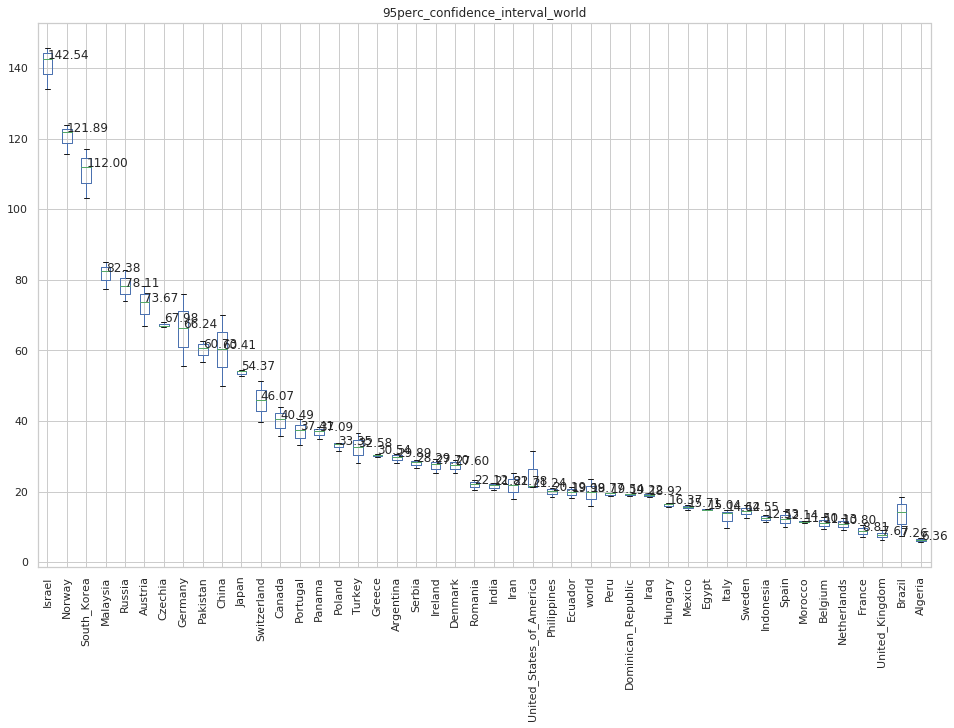

In [158]:
wd_curr[['quantile25_rep', 'quantile75_rep', 'average_rep']].T.plot(kind='box', figsize=(16,10), rot = 90)
df = wd_curr


title = '95perc_confidence_interval_world'
plt.title(title)
s = 1
for i in df.iterrows():
#     print(i[0])
    plt.annotate("{:.2f}".format(i[1]['average_rep']),(s,i[1]['average_rep']))
#     plt.annotate("{:.2f}".format(i[1]['quantile25_rep']),(s,i[1]['quantile25_rep']))
#     plt.annotate("{:.2f}".format(i[1]['quantile75_rep']),(s,i[1]['quantile75_rep']))
    s = s + 1
    
plt.savefig('./img/' + title)

In [159]:
wd_curr

known       cases    deaths  quantile25  \
country                                                                 
Israel                     3706.042    9248.000    65.000       0.014   
Norway                     3364.064    5863.000    69.000       0.016   
South_Korea                8959.611   10384.000   200.000       0.019   
Malaysia                   2075.984    3963.000    63.000       0.024   
Russia                     1812.134    7497.000    58.000       0.024   
Austria                    7161.029   12640.000   243.000       0.030   
Czechia                    2392.906    5017.000    88.000       0.030   
Germany                   49307.891  103228.000  1861.000       0.036   
Pakistan                   1408.955    4072.000    58.000       0.032   
China                     80634.767   82784.000  3337.000       0.040   
Japan                      1739.946    3906.000    80.000       0.037   
Switzerland               11813.471   22164.000   641.000       0.050   
Canada                     6154.920   17883.000   380.000       0.056   
Portugal                   5162.040   12442.000   345.000       0.060   
Panama                      875.345    2249.000    59.000       0.052   
Poland                     1721.109    4848.000   129.000       0.063   
Turkey                     9447.013   34109.000   725.000       0.071   
Greece                      989.629    1832.000    81.000       0.066   
Argentina                   717.428    1715.000    60.000       0.065   
Serbia                      690.216    2447.000    61.000       0.069   
Ireland                    2326.581    5709.000   210.000       0.079   
Denmark                    2240.747    5071.000   203.000       0.079   
Romania                    1610.680    4417.000   182.000       0.098   
India                      1300.351    5194.000   149.000       0.098   
Iran                      33739.892   62589.000  3872.000       0.111   
United_States_of_America 136969.005  398809.000 12895.000       0.093   
Philippines                1429.272    3764.000   177.000       0.108   
Ecuador                    1757.850    3995.000   220.000       0.110   
world                    644368.611 1391194.000 81471.000       0.126   
Peru                        836.191    2954.000   107.000       0.107   
Dominican_Republic          753.343    1956.000    98.000       0.107   
Iraq                        484.359    1031.000    64.000       0.102   
Hungary                     379.842     895.000    58.000       0.120   
Mexico                      886.205    2785.000   141.000       0.136   
Egypt                       511.497    1322.000    85.000       0.136   
Italy                     80799.924  135586.000 17129.000       0.209   
Sweden                     3440.546    7693.000   591.000       0.159   
Indonesia                  1107.695    2738.000   221.000       0.177   
Spain                     67013.334  140510.000 13798.000       0.203   
Morocco                     414.011    1184.000    90.000       0.180   
Belgium                    9056.827   22194.000  2035.000       0.216   
Netherlands                9074.162   19580.000  2101.000       0.223   
France                    36416.057   78167.000 10328.000       0.279   
United_Kingdom            18895.720   55242.000  6159.000       0.319   
Brazil                     4404.981   13717.000   667.000       0.141   
Algeria                     493.809    1468.000   194.000       0.351   

                          quantile75  average  death_est_avg  quantile25_rep  \
country                                                                        
Israel                         0.022    0.018          2.500         145.758   
Norway                         0.026    0.021          2.500         123.794   
South_Korea                    0.026    0.022          2.500         103.069   
Malaysia                       0.039    0.030          2.500          84.947   
Russia                         0.040    0.032

In [180]:
br_state_file = './'
kaggle.api.authenticate()
kaggle.api.dataset_download_files('unanimad/corona-virus-brazil/metadata', path=br_state_file, unzip=True)

br_state = pd.read_csv('brazil_covid19.csv')
# br_state['total'] = br_state['cases'] + br_state['refuses']
# br_state['total_susp'] = br_state['cases'] +  br_state['refuses'] + br_state['suspects']
# br_state['positive_rate'] = br_state['cases'] / br_state['total'] * 100
br_state_copy = br_state.copy()
br_state = br_state[br_state['date'] == str_today]
br_state = br_state.set_index('state', drop=True)
br_state['death_rate'] = br_state['deaths'] / br_state['cases'] * 100
br_state_data = pd.read_csv('br_states_data.csv')
br_state_data = br_state_data.drop(['Bandeira', 'Sede de governo','Alfabetização (2016)', 'Mortalidade infantil (2016)', 'Expectativa de vida (2016)'], axis = 1)
br_state_data.columns = ['state', 'state_2digits', 'area', 'population', 'density', 'gdp', 'share','gdp_per_capita', 'hdi']
br_state_data = br_state_data.set_index('state', drop=True)
br_state_data = br_state.merge(br_state_data, on='state')
br_state_data['area'] = br_state_data['area'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['population'] = br_state_data['population'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['gdp'] = br_state_data['gdp'].str.replace(',','').str.replace('\xa0','').astype(float)
br_state_data['gdp_per_capita'] = br_state_data['gdp_per_capita'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['hdi'] = br_state_data['hdi'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['density'] = br_state_data['density'].str.replace(',','.').str.replace('\xa0','').astype(float)
# br_state_data['tests_per_1000'] = br_state_data['total'] / br_state_data['population'] * 1000
# br_state_data = br_state_data.set_index('state_2digits', drop = True)
# br_state
print(br_state_copy['date'].max())

2020-04-08


In [181]:
br_date = br_state_copy.groupby('date').sum()
br_date['death_rate'] = (br_date['deaths'] / br_date['cases']).fillna(0)
br_date['new_cases'] = br_date['cases'].diff().fillna(0)
br_date = br_date[br_date.index > '2020-02-20']

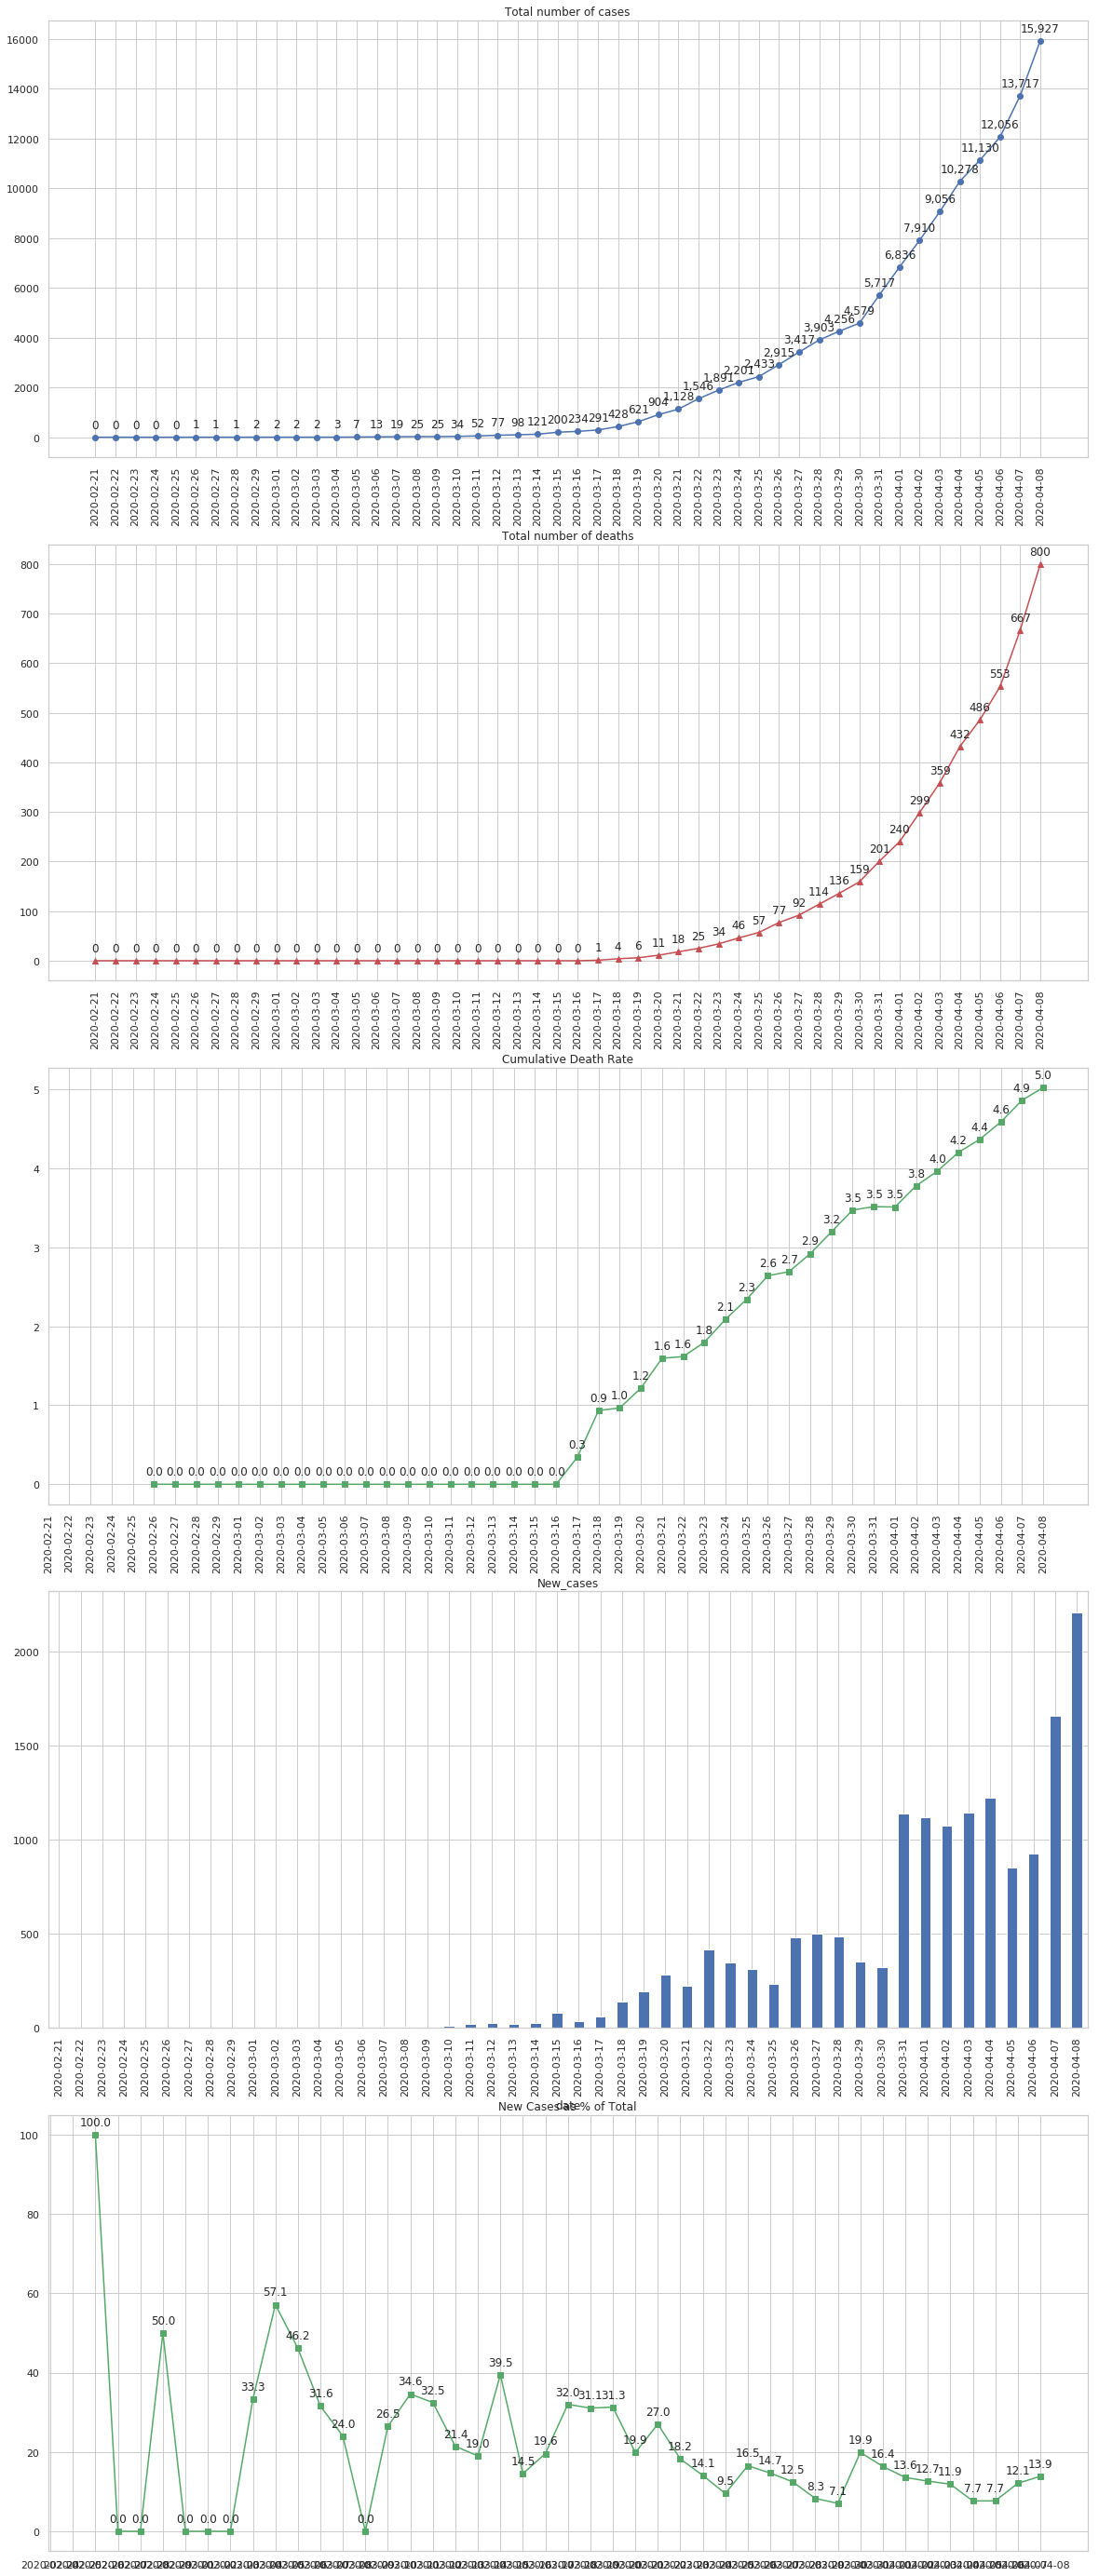

<Figure size 432x288 with 0 Axes>

In [182]:
plt.figure(figsize = (20,50))

plt.subplot('511')
xs = br_date.index.values
ys = br_date['cases']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
plt.xticks(xs, xs, rotation='vertical')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = br_date['deaths']
plt.plot(xs, ys, 'r^-')
plt.xticks(xs, xs, rotation='vertical')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = br_date['deaths'] / br_date['cases'] * 100
plt.plot(xs, ys, 'gs-')
plt.xticks(xs, xs, rotation='vertical')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('New_cases')
ys = br_date['new_cases']
# plt.plot(x = xs, y = ys)
br_date['new_cases'].plot(kind = 'bar')
# for x,y in zip(xs,ys):
#     label = "{:.0f}".format(y)
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center

# plt.savefig('./img/br_overview')

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = br_date['new_cases'] / br_date['cases'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('./img/ny_overview')
plt.show()

plt.savefig('./img/br_overview')
plt.show()

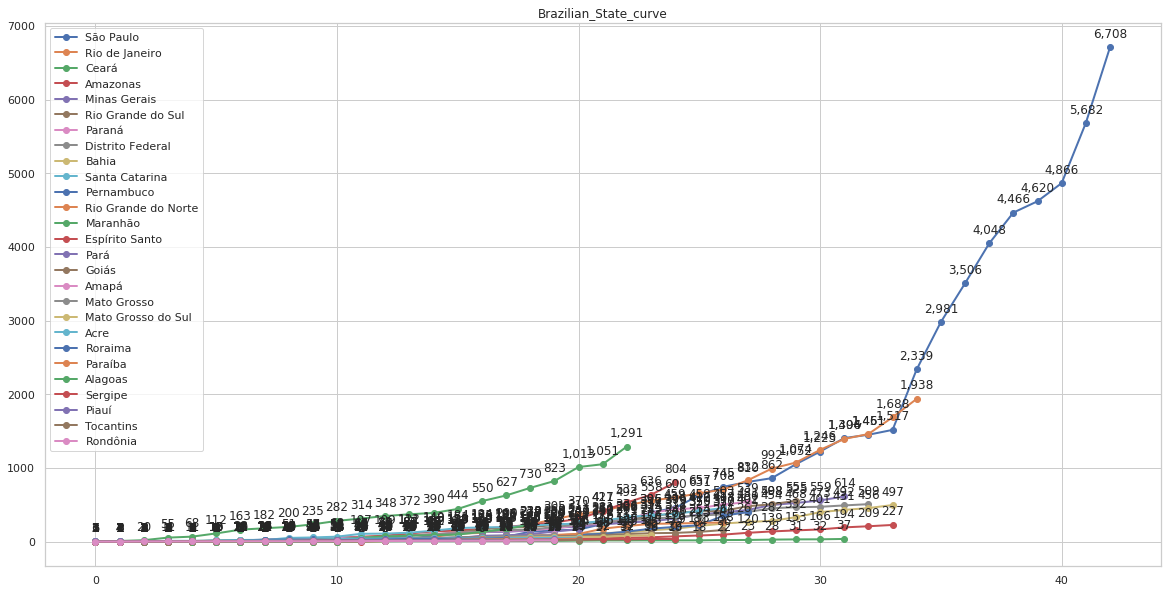

In [183]:
pt_br_state = br_state_copy.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state = pt_br_state.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

# plt.rc('font', **font)
title = 'Brazilian_State_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

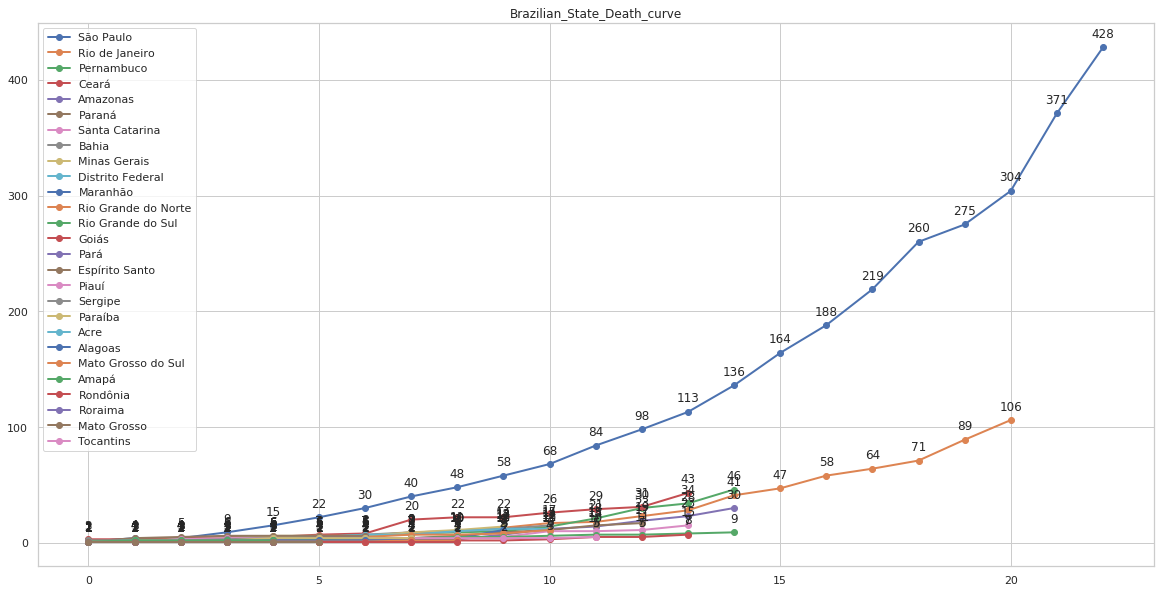

In [184]:
pt_br_state_death = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state_death = pt_br_state_death.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_death.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

# plt.rc('font', **font)
title = 'Brazilian_State_Death_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

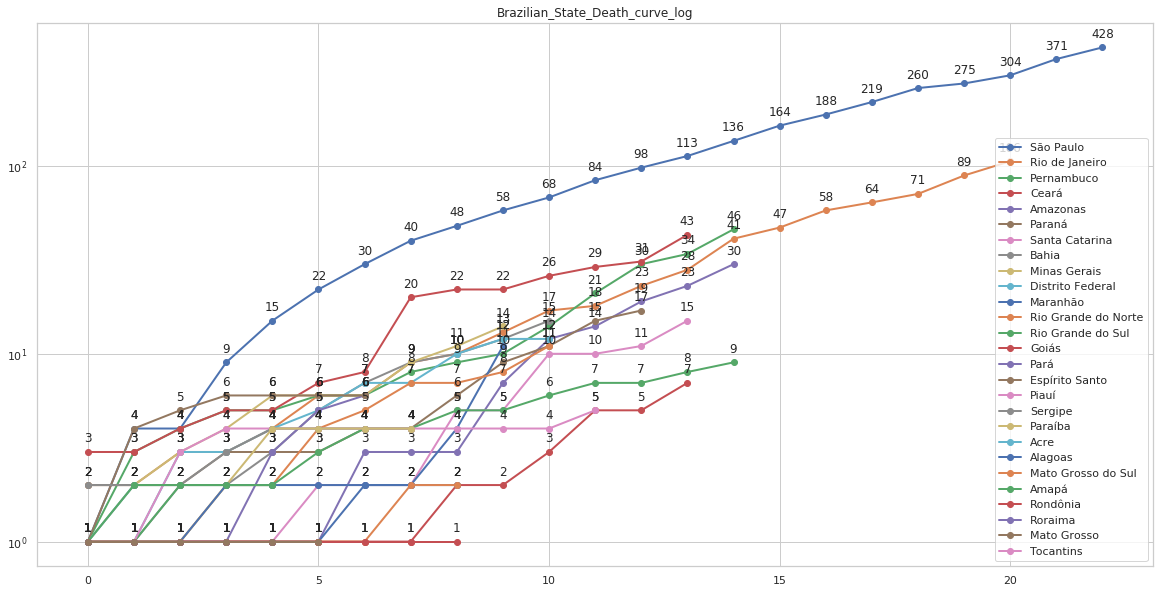

In [185]:
pt_br_state_death = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state_death = pt_br_state_death.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_death.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))
plt.yscale('log')
# plt.rc('font', **font)
title = 'Brazilian_State_Death_curve_log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

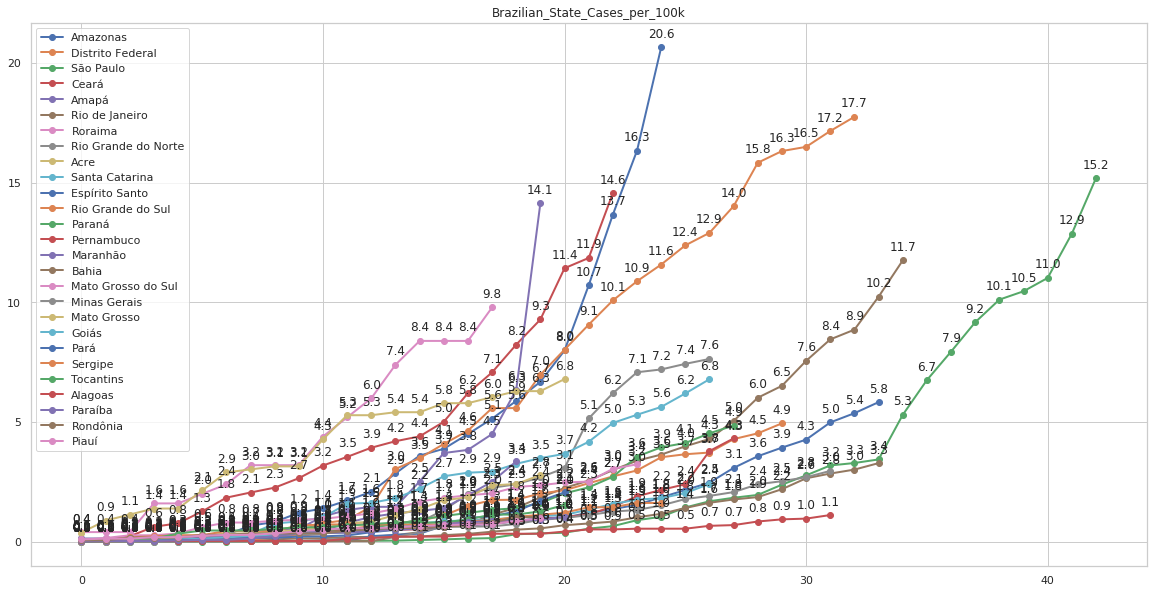

In [186]:
pt_br_state_adj =  pt_br_state.div(br_state_data['population'], axis = 0) * 100000
pt_br_state_adj = pt_br_state_adj.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_adj.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Brazilian_State_Cases_per_100k'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.1f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

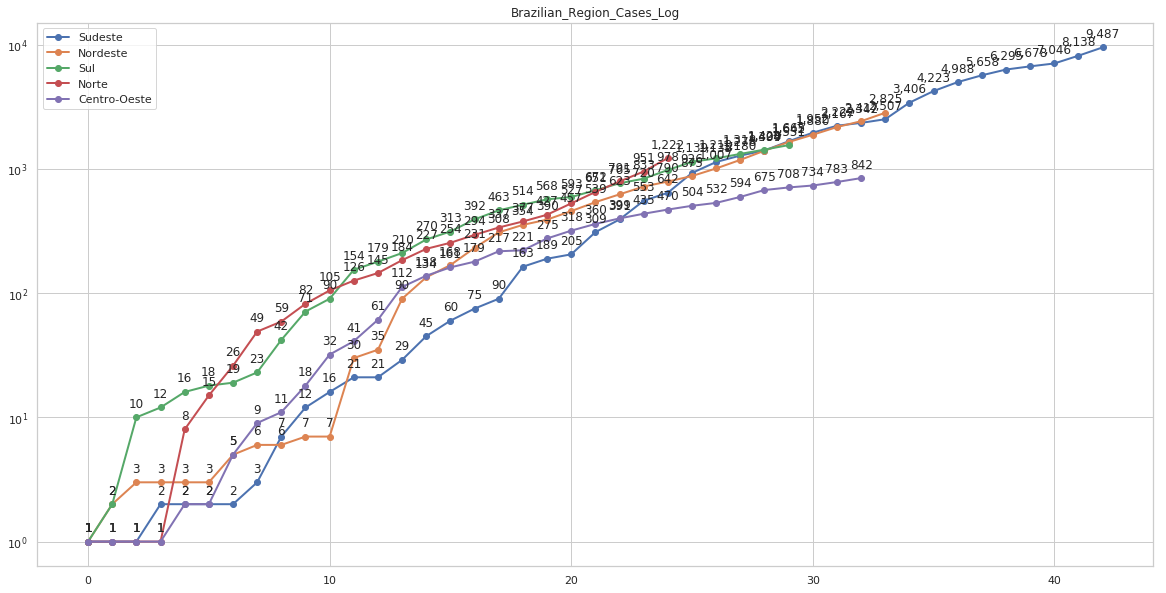

In [187]:
pt_br_state_adj = br_state_copy.pivot_table(values = 'cases', index = 'region', columns = 'date', aggfunc='sum')
pt_br_state_adj = pt_br_state_adj.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_adj.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))
plt.yscale('log')

plt.rc('font', **font)
title = 'Brazilian_Region_Cases_Log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

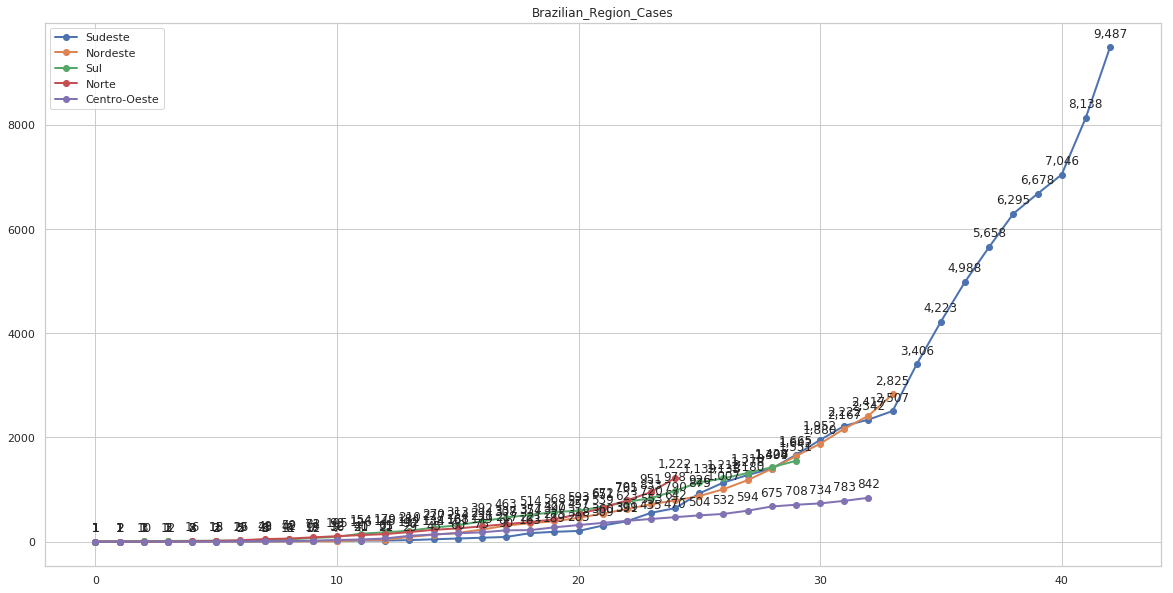

In [188]:
pt_br_state_adj = br_state_copy.pivot_table(values = 'cases', index = 'region', columns = 'date', aggfunc='sum')
pt_br_state_adj = pt_br_state_adj.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_adj.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))
# plt.yscale('log')

plt.rc('font', **font)
title = 'Brazilian_Region_Cases'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

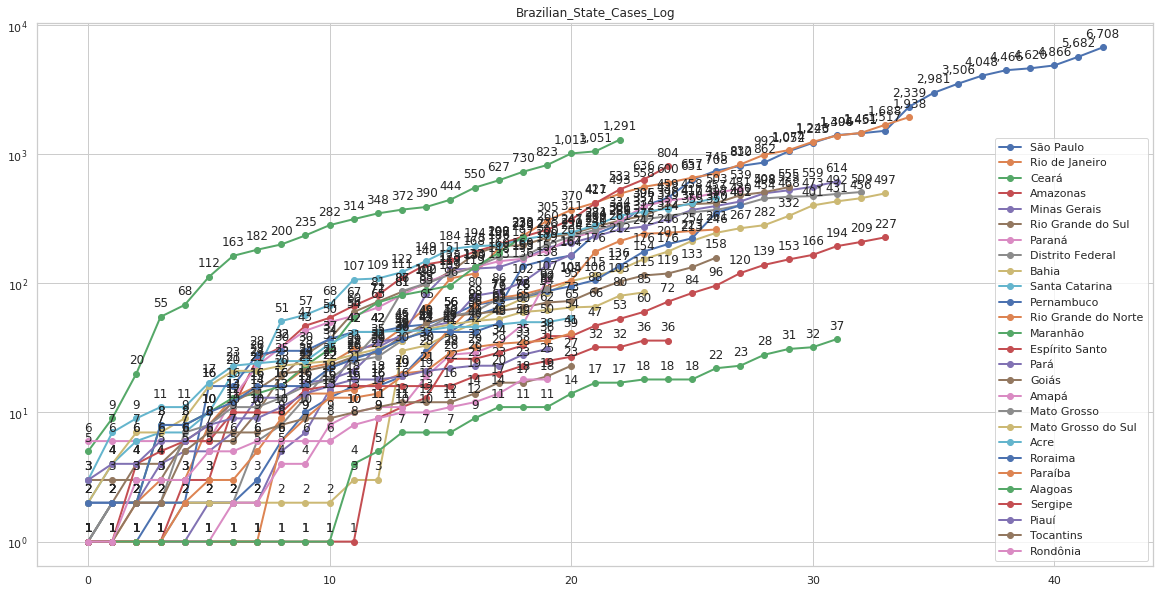

In [189]:
pt_br_state_adj =  pt_br_state
pt_br_state_adj = pt_br_state_adj.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_adj.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))
plt.yscale('log')

plt.rc('font', **font)
title = 'Brazilian_State_Cases_Log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

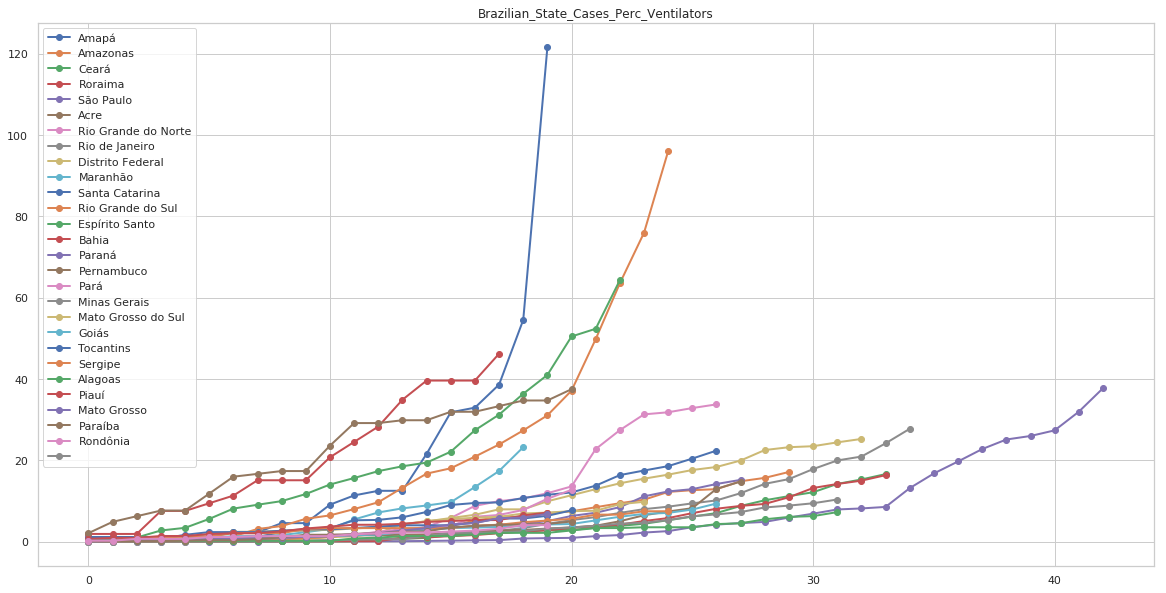

In [190]:
pt_br_state_adj =  pt_br_state.div(resp['equipments'], axis = 0) * 100
pt_br_state_adj = pt_br_state_adj.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_adj.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Brazilian_State_Cases_Perc_Ventilators'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

In [191]:
pt_br_state_death  = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc='sum') / pt_br_state * 100
# pt_br_state_death.loc['Ceará']['2020-03-28'] = 4
# pt_br_state_death.loc['Rio Grande do Sul']['2020-03-28'] = 2
pt_br_state_death = pt_br_state_death.sort_values(by=str_today, ascending = False)


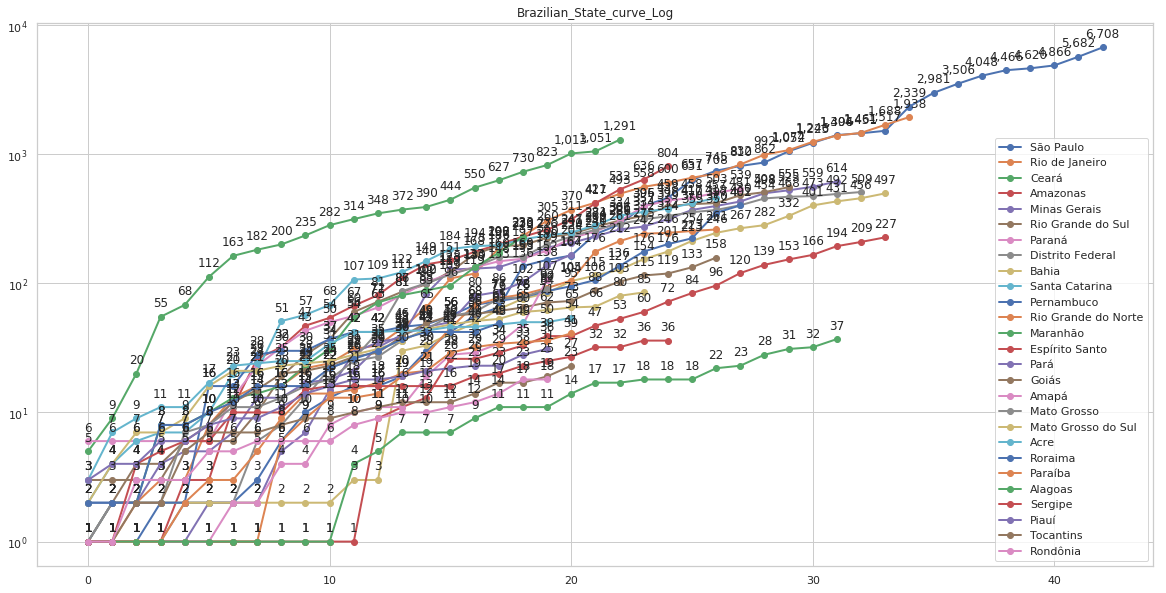

In [192]:
pt_br_state = br_state_copy.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state = pt_br_state.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))
plt.yscale('log')
plt.rc('font', **font)
title = 'Brazilian_State_curve_Log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        xs = temp.index
        ys = temp
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

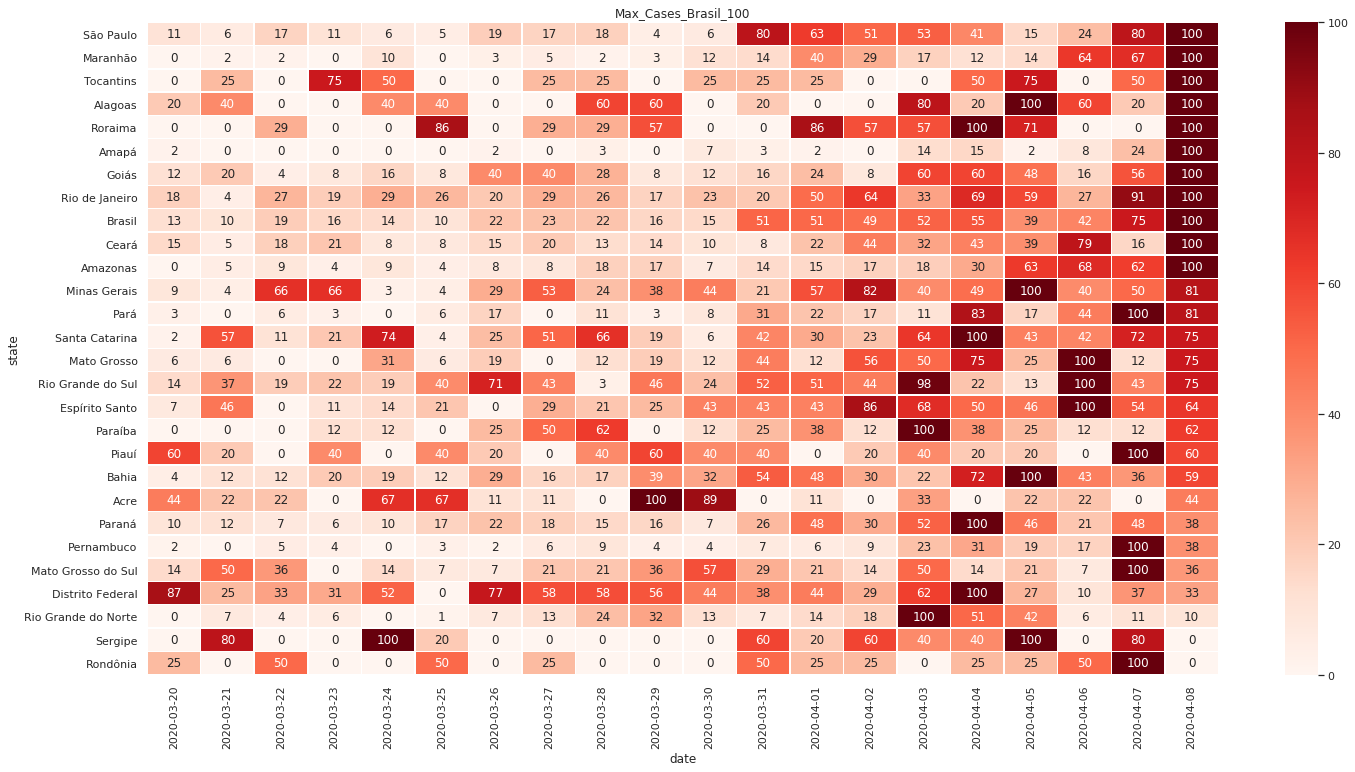

In [193]:
plt.figure(figsize = (24,12))
title = 'Max_Cases_Brasil_100'
pt_br_state_daily = pt_br_state.diff(axis = 1)
df_aux = pt_br_state_daily[pt_br_state_daily.columns[-20:]]
df_aux.loc['Brasil'] = df_aux.sum()
# df_aux.columns = df_aux.columns.date
df_result = df_aux.div(df_aux.max(axis = 1), axis = 0) * 100
plt.title(title)
sns.heatmap(df_result.sort_values(by=str_today, ascending = False), annot = True, linewidths = 0.5, cmap='Reds', fmt=',.0f')
plt.savefig('./img/' +title)
# df_result
# pt_br_state

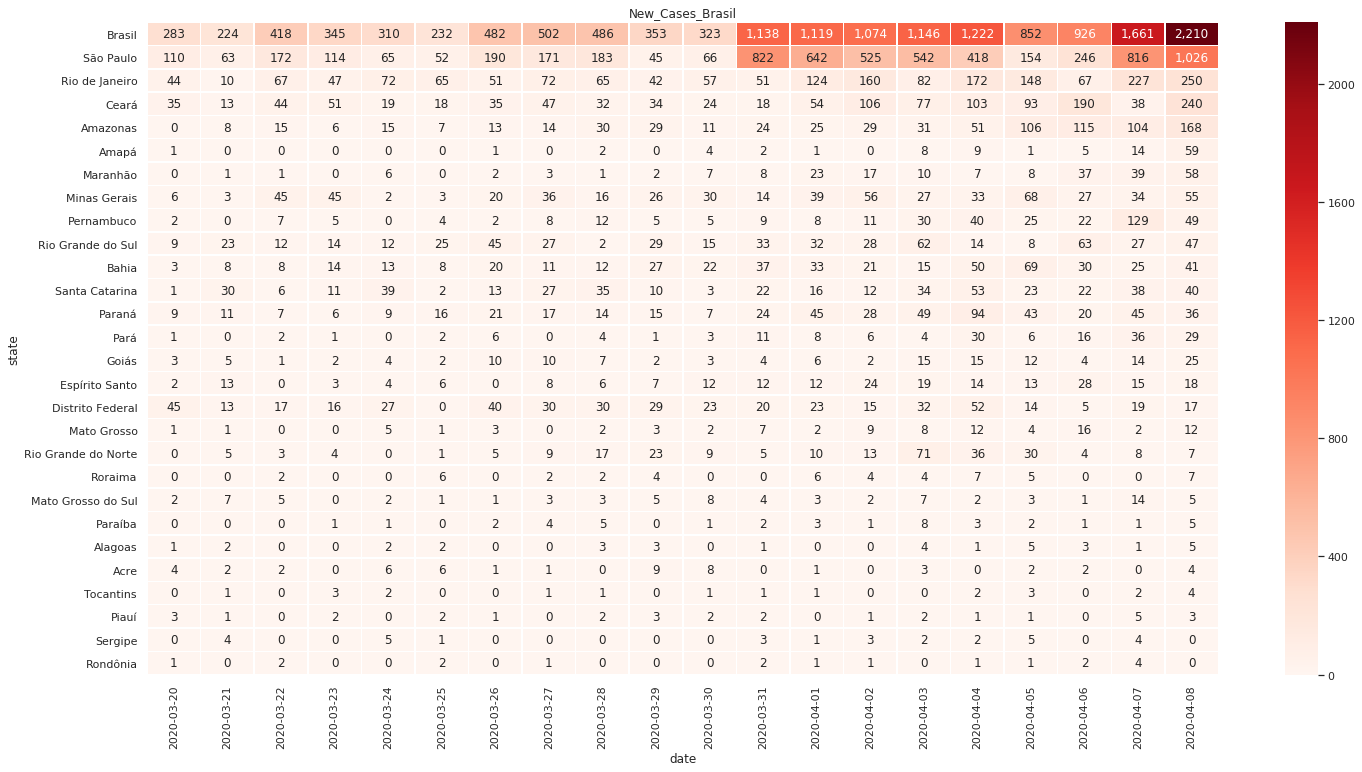

In [194]:
plt.figure(figsize = (24,12))
title = 'New_Cases_Brasil'
pt_br_state_daily = pt_br_state.diff(axis = 1)
df_aux = pt_br_state_daily[pt_br_state_daily.columns[-20:]]
df_aux.loc['Brasil'] = df_aux.sum()
# df_aux.columns = df_aux.columns.date
df_result = df_aux
plt.title(title)
sns.heatmap(df_result.sort_values(by=str_today, ascending = False), annot = True, linewidths = 0.5, cmap='Reds', fmt=',.0f')
plt.savefig('./img/' + title)
# df_result
# pt_br_state

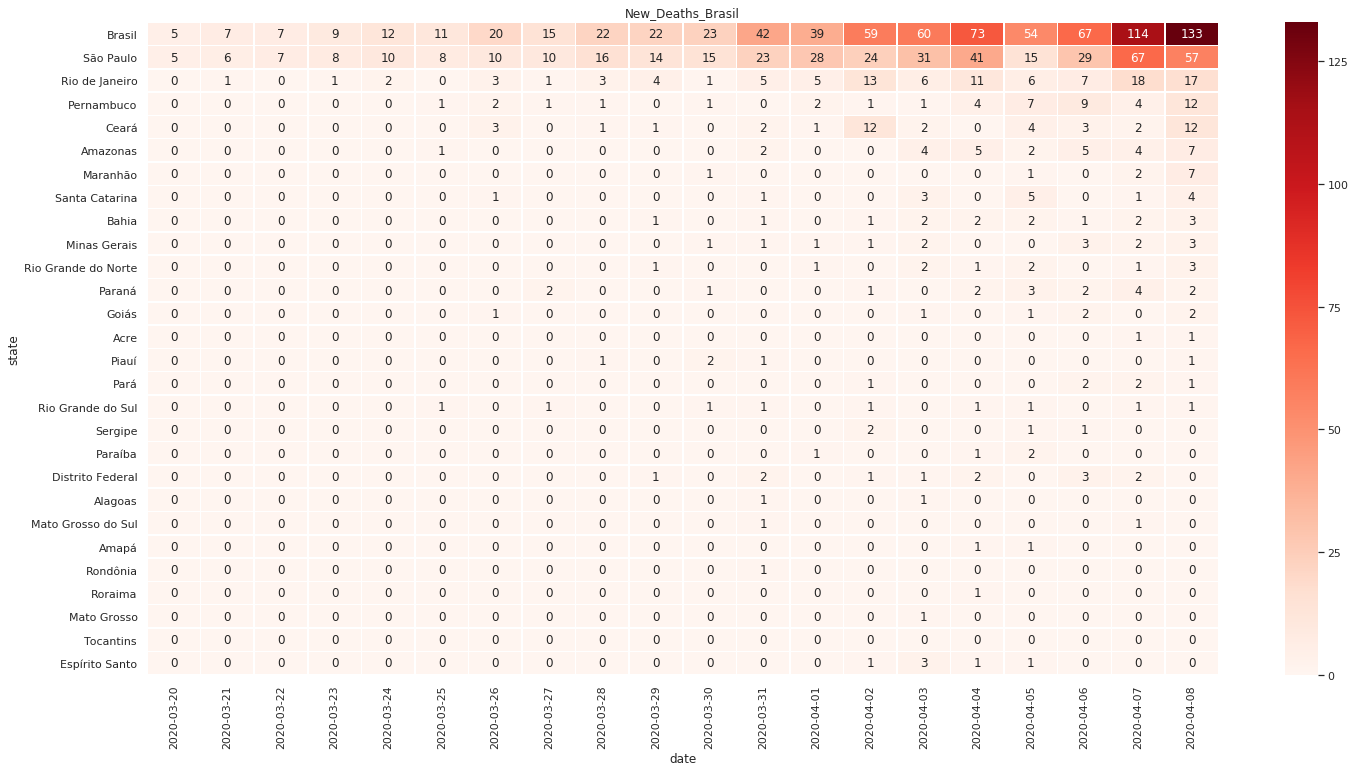

In [195]:
pt_br_state_death = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state_death = pt_br_state_death.sort_values(by=str_today, ascending = False).diff(axis = 1)
plt.figure(figsize = (24,12))
title = 'New_Deaths_Brasil'
pt_br_state_daily = pt_br_state_death
df_aux = pt_br_state_daily[pt_br_state_daily.columns[-20:]]
df_aux.loc['Brasil'] = df_aux.sum()
# df_aux.columns = df_aux.columns.date
df_result = df_aux
plt.title(title)
sns.heatmap(df_result.sort_values(by=str_today, ascending = False), annot = True, linewidths = 0.5, cmap='Reds', fmt=',.0f')
plt.savefig('./img/' + title)
# df_result
# pt_br_state

In [196]:
br_cases = pd.DataFrame(br_state_copy.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc = 'sum').fillna(0).diff(axis = 1).fillna(0).unstack())
br_cases.columns = ['cases']
br_cases = br_cases.reset_index()

In [197]:
br_cases['rel_date'] = (dt.datetime.now() - pd.to_datetime(br_cases['date'])).dt.days
br_cases['known'] = HDT(br_cases['rel_date'])
br_cases['known_cases'] = br_cases['known'] * br_cases['cases']

br_total_cases = br_cases.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc = 'sum').cumsum(axis = 1)
br_total_cases.loc['Brasil'] = br_total_cases.sum()
total_cases = br_total_cases.loc['Brasil']
br_total_cases

br_known_cases = br_cases.pivot_table(values = 'known_cases', index = 'state', columns = 'date', aggfunc = 'sum').cumsum(axis = 1)
df = br_known_cases.sort_values(by=str_today, ascending = False)
br_known_cases.loc['Brasil'] = br_known_cases.sum()
br_known_cases

date                 2020-01-30  2020-01-31  2020-02-01  2020-02-02  \
state                                                                 
Acre                      0.000       0.000       0.000       0.000   
Alagoas                   0.000       0.000       0.000       0.000   
Amapá                     0.000       0.000       0.000       0.000   
Amazonas                  0.000       0.000       0.000       0.000   
Bahia                     0.000       0.000       0.000       0.000   
Ceará                     0.000       0.000       0.000       0.000   
Distrito Federal          0.000       0.000       0.000       0.000   
Espírito Santo            0.000       0.000       0.000       0.000   
Goiás                     0.000       0.000       0.000       0.000   
Maranhão                  0.000       0.000       0.000       0.000   
Mato Grosso               0.000       0.000       0.000       0.000   
Mato Grosso do Sul        0.000       0.000       0.000       0.000   
Minas Gerais              0.000       0.000       0.000       0.000   
Paraná                    0.000       0.000       0.000       0.000   
Paraíba                   0.000       0.000       0.000       0.000   
Pará                      0.000       0.000       0.000       0.000   
Pernambuco                0.000       0.000       0.000       0.000   
Piauí                     0.000       0.000       0.000       0.000   
Rio Grande do Norte       0.000       0.000       0.000       0.000   
Rio Grande do Sul         0.000       0.000       0.000       0.000   
Rio de Janeiro            0.000       0.000       0.000       0.000   
Rondônia                  0.000       0.000       0.000       0.000   
Roraima                   0.000       0.000       0.000       0.000   
Santa Catarina            0.000       0.000       0.000       0.000   
Sergipe                   0.000       0.000       0.000       0.000   
São Paulo                 0.000       0.000       0.000       0.000   
Tocantins                 0.000       0.000       0.000       0.000   
Brasil                    0.000       0.000       0.000       0.000   

date                 2020-02-03  2020-02-04  2020-02-05  2020-02-06  \
state                                                                 
Acre                      0.000       0.000       0.000       0.000   
Alagoas                   0.000       0.000       0.000       0.000   
Amapá                     0.000       0.000       0.000       0.000   
Amazonas                  0.000       0.000       0.000       0.000   
Bahia                     0.000       0.000       0.000       0.000   
Ceará                     0.000       0.000       0.000       0.000   
Distrito Federal          0.000       0.000       0.000       0.000   
Espírito Santo            0.000       0.000       0.000       0.000   
Goiás                     0.000       0.000       0.000       0.000   
Maranhão                  0.000       0.000       0.000       0.000   
Mato Grosso               0.000       0.000       0.000       0.000   
Mato Grosso do Sul        0.000       0.000       0.000       0.000   
Minas Gerais              0.000       0.000       0.000       0.000   
Paraná                    0.000       0.000       0.000       0.000   
Paraíba                   0.000       0.000       0.000       0.000   
Pará                      0.000       0.000       0.000       0.000   
Pernambuco                0.000       0.000       0.000       0.000   
Piauí                     0.000       0.000       0.000       0.000   
Rio Grande do Norte       0.000       0.000       0.000       0.000   
Rio Grande do Sul         0.000       0.000       0.000       0.000   
Rio de Janeiro            0.000       0.000       0.000       0.000   
Rondônia                  0.000       0.000       0.000       0.000   
Roraima                   0.000       0.000       0.000       0.000   
Santa Catarina            0.000       0.000       0.000       0.000   
Sergipe                

In [198]:
br_deaths = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc = 'sum').fillna(0)
# br_deaths.loc['Ceará']['2020-03-28'] = 4
# br_deaths.loc['Rio Grande do Sul']['2020-03-28'] = 2
br_deaths.loc['Brasil'] = br_deaths.sum()
br_deaths

date                 2020-01-30  2020-01-31  2020-02-01  2020-02-02  \
state                                                                 
Acre                          0           0           0           0   
Alagoas                       0           0           0           0   
Amapá                         0           0           0           0   
Amazonas                      0           0           0           0   
Bahia                         0           0           0           0   
Ceará                         0           0           0           0   
Distrito Federal              0           0           0           0   
Espírito Santo                0           0           0           0   
Goiás                         0           0           0           0   
Maranhão                      0           0           0           0   
Mato Grosso                   0           0           0           0   
Mato Grosso do Sul            0           0           0           0   
Minas Gerais                  0           0           0           0   
Paraná                        0           0           0           0   
Paraíba                       0           0           0           0   
Pará                          0           0           0           0   
Pernambuco                    0           0           0           0   
Piauí                         0           0           0           0   
Rio Grande do Norte           0           0           0           0   
Rio Grande do Sul             0           0           0           0   
Rio de Janeiro                0           0           0           0   
Rondônia                      0           0           0           0   
Roraima                       0           0           0           0   
Santa Catarina                0           0           0           0   
Sergipe                       0           0           0           0   
São Paulo                     0           0           0           0   
Tocantins                     0           0           0           0   
Brasil                        0           0           0           0   

date                 2020-02-03  2020-02-04  2020-02-05  2020-02-06  \
state                                                                 
Acre                          0           0           0           0   
Alagoas                       0           0           0           0   
Amapá                         0           0           0           0   
Amazonas                      0           0           0           0   
Bahia                         0           0           0           0   
Ceará                         0           0           0           0   
Distrito Federal              0           0           0           0   
Espírito Santo                0           0           0           0   
Goiás                         0           0           0           0   
Maranhão                      0           0           0           0   
Mato Grosso                   0           0           0           0   
Mato Grosso do Sul            0           0           0           0   
Minas Gerais                  0           0           0           0   
Paraná                        0           0           0           0   
Paraíba                       0           0           0           0   
Pará                          0           0           0           0   
Pernambuco                    0           0           0           0   
Piauí                         0           0           0           0   
Rio Grande do Norte           0           0           0           0   
Rio Grande do Sul             0           0           0           0   
Rio de Janeiro                0           0           0           0   
Rondônia                      0           0           0           0   
Roraima                       0           0           0           0   
Santa Catarina                0           0           0           0   
Sergipe                

In [199]:
a = 667 / (4404 / 0.086)
b = (5029/ 0.084)
c = (6836 + 5717) / 2 / 0.097
print(a)
print(a * b)
print(a * b / 0.046)
print(c)

0.013024977293369664
779.7929858137624
16952.021430733963
64706.18556701031


In [200]:
a = 299 / (2074 / 0.09) 
b = (2418 / 0.08)
c = (6836 + 5717) / 2 / 0.097
print(a)
print(a * b)
print(a * b / 0.035)
print(c)

0.012974927675988427
392.1671890067502
11204.77682876429
64706.18556701031


In [201]:
br_death_rate = (br_deaths / br_known_cases * 100).fillna(0)

In [202]:
br_death_rate = br_death_rate[br_death_rate[str_today] > 0]
# br_death_rate

In [203]:
death_est = [1.2, 1.3, 1.4]

br_reported = (death_est[1] / br_death_rate * 100).replace(np.inf, np.nan)
# known_cases = br_known_cases.loc['Brasil']
br_reported = br_reported[br_reported.columns[-4:]].sort_values(by = str_today, ascending = False)
br_reported

date                 2020-04-05  2020-04-06  2020-04-07  2020-04-08
state                                                              
Rio Grande do Sul        40.747      41.173      36.046      32.041
Mato Grosso              29.385      30.143      30.154      30.154
Distrito Federal         47.698      33.412      27.853      27.853
Mato Grosso do Sul       46.653      46.701      23.391      23.391
Minas Gerais             50.786      34.000      27.836      21.871
Roraima                  21.346      21.346      21.346      21.346
Acre                        nan         nan      37.496      18.748
Espírito Santo           16.068      16.289      16.303      16.303
Santa Catarina           22.818      22.922      20.858      15.296
Bahia                    24.813      22.474      18.740      14.992
Paraná                   25.287      20.776      15.253      13.458
Ceará                    18.051      16.494      15.437      11.129
Goiás                    23.659      14.233      14.249      10.178
Rio Grande do Norte      15.337      15.364      13.449       9.781
Alagoas                   9.138       9.209       9.212       9.212
Brasil                   13.345      11.807       9.803       8.174
Rondônia                  8.053       8.148       8.171       8.171
Rio de Janeiro           12.856      11.633       9.295       7.805
Amazonas                 14.094      10.672       8.842       6.779
Pará                     38.844      13.201       7.962       6.635
São Paulo                 9.763       8.870       7.281       6.311
Amapá                     6.097       6.215       6.256       6.256
Sergipe                   7.139       5.354       5.360       5.360
Paraíba                   4.711       4.723       4.725       4.725
Maranhão                 23.434      24.310      12.211       4.441
Piauí                     4.060       4.060       4.067       3.254
Pernambuco                5.096       3.602       3.200       2.365

In [204]:
# tps = pd.DataFrame([known_cases, total_cases - known_cases], index = ['wo_outcome', 'w_outcome']).T
# tps = tps[tps['w_outcome'] > 0]
# tps = tps.div(tps.sum(1), axis=0)
# tps.plot(kind='bar', stacked=True, figsize = (20,4))

# title = 'Share_cases_w_Outcome'
# plt.title(title)
# plt.savefig('./img/' + title)

In [205]:
br_curr = br_known_cases[[str_today]]
br_curr['cases'] = br_total_cases[str_today]
br_curr['deaths'] = br_deaths[str_today]
br_curr.columns = ['known', 'cases', 'deaths']

br_copy = br_curr[br_curr['deaths'] > 0]
br_copy['not_known'] = (br_copy['cases'] - br_copy['known']) / br_copy['cases']
br_copy['known'] = ( br_copy['known']) / br_copy['cases']
br_copy['total_cases'] = (br_copy['deaths'] / br_copy['known']) / (death_est[1] / 100)
br_copy.drop(['cases', 'deaths'], axis = 1).sort_values(by = 'total_cases', ascending = False)
# br_known_cases[[str_today]]

known  not_known  total_cases
state                                             
Brasil               0.316      0.684   194858.121
São Paulo            0.310      0.690   106286.919
Rio de Janeiro       0.328      0.672    24831.591
Pernambuco           0.209      0.791    16954.518
Amazonas             0.195      0.805    11860.274
Ceará                0.285      0.715    11600.295
Maranhão             0.163      0.837     5179.593
Paraná               0.327      0.673     4004.948
Bahia                0.348      0.652     3315.045
Santa Catarina       0.386      0.614     2987.727
Minas Gerais         0.384      0.616     2807.377
Rio Grande do Norte  0.317      0.683     2668.381
Pará                 0.183      0.817     2516.908
Distrito Federal     0.505      0.495     1827.478
Rio Grande do Sul    0.400      0.600     1732.158
Amapá                0.090      0.910     1710.331
Goiás                0.347      0.653     1552.351
Espírito Santo       0.331      0.669     1392.366
Piauí                0.404      0.596      952.676
Paraíba              0.355      0.645      867.785
Sergipe              0.458      0.542      671.605
Alagoas              0.383      0.617      401.663
Mato Grosso do Sul   0.423      0.577      363.387
Mato Grosso          0.258      0.742      298.466
Acre                 0.534      0.466      288.030
Roraima              0.335      0.665      229.547
Rondônia             0.349      0.651      220.290

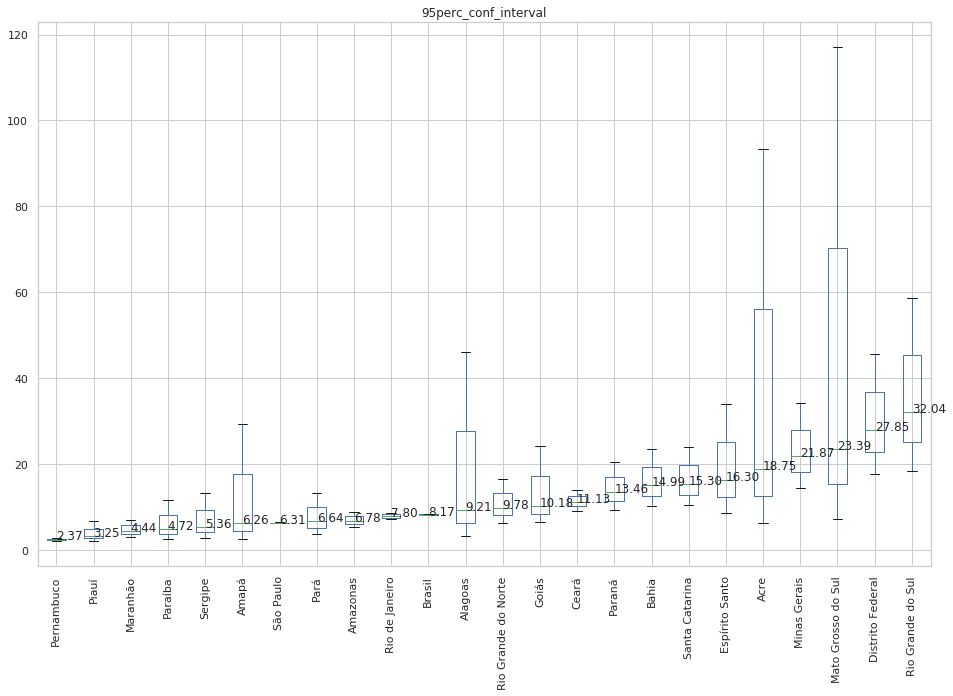

In [206]:
br_curr['quantile25'] = [conf_int(count = br_curr.loc[i]['deaths'], nobs = br_curr.loc[i]['known'], method = 'binom_test')[0] for i in br_curr.index]
br_curr['quantile75'] = [conf_int(count = br_curr.loc[i]['deaths'], nobs = br_curr.loc[i]['known'], method = 'binom_test')[1] for i in br_curr.index]
br_curr['average'] = br_curr['deaths'] / br_curr['known']
br_curr['quantile25_rep'] = (death_est[0] / br_curr['quantile25']).replace(np.inf, np.nan)
br_curr['quantile75_rep'] = (death_est[2] / br_curr['quantile75']).replace(np.inf, np.nan)
br_curr['average_rep'] = (death_est[1] / br_curr['average']).replace(np.inf, np.nan)
br_curr = br_curr[br_curr['deaths'] >= 2].sort_values(by='average_rep')

# proportion.proportion_confint(count = br_curr.loc['Brasil']['deaths'], nobs = br_curr.loc['Brasil']['known'], method = 'binom_test')
# br_curr.loc[0]['deaths']
    
br_curr[['quantile25_rep', 'quantile75_rep', 'average_rep']].T.plot(kind='box', figsize=(16,10), rot = 90)
df = br_curr


title = '95perc_conf_interval'
plt.title(title)
s = 1
for i in df.iterrows():
#     print(i[0])
    plt.annotate("{:.2f}".format(i[1]['average_rep']),(s,i[1]['average_rep']))
#     plt.annotate("{:.2f}".format(i[1]['quantile25_rep']),(s,i[1]['quantile25_rep']))
#     plt.annotate("{:.2f}".format(i[1]['quantile75_rep']),(s,i[1]['quantile75_rep']))
    s = s + 1
    
plt.savefig('./img/' + title)
# df

In [207]:
df['est_cases'] = df['cases'] / df['average_rep'] * 100
# df['est_cases'] = df['est_cases'] / 71000 * 64000
df['est_cases'].sort_values(ascending = False)

state
Brasil                194858.121
São Paulo             106286.919
Rio de Janeiro         24831.591
Pernambuco             16954.518
Amazonas               11860.274
Ceará                  11600.295
Maranhão                5179.593
Paraná                  4004.948
Bahia                   3315.045
Santa Catarina          2987.727
Minas Gerais            2807.377
Rio Grande do Norte     2668.381
Pará                    2516.908
Distrito Federal        1827.478
Rio Grande do Sul       1732.158
Amapá                   1710.331
Goiás                   1552.351
Espírito Santo          1392.366
Piauí                    952.676
Paraíba                  867.785
Sergipe                  671.605
Alagoas                  401.663
Mato Grosso do Sul       363.387
Acre                     288.030
Name: est_cases, dtype: float64

In [208]:
df_tests = pd.read_csv('20200401_tests.csv')
df_tests['total_tests'] = df_tests['fast tests'] + df_tests['RT-PCR']
df_tests = df_tests.merge(br_state_data[['population']], on='state')
df_tests

state  fast tests  RT-PCR  total_tests   population
0                  Acre        2012     120         2132   795145.000
1               Alagoas        6986     888         7874  3327551.000
2                 Amapá        1854     840         2694   756500.000
3              Amazonas        8586    1872        10458  3893763.000
4                 Bahia       31634    2640        34274 15150143.000
5                 Ceará       18057    2280        20337  8867448.000
6      Distrito Federal        7492    4272        11764  2867869.000
7        Espírito Santo        9010    2232        11242  3894899.000
8                 Goiás       13717    2064        15781  6551322.000
9              Maranhão       14381     600        14981  6861924.000
10          Mato Grosso        7245     624         7869  3236578.000
11   Mato Grosso do Sul        7047    1776         8823  2630098.000
12         Minas Gerais       50920    4584        55504 20777672.000
13                 Pará       14806    3384        18190  8101180.000
14              Paraíba        8870    1032         9902  3950359.000
15               Paraná       26199    2832        29031 11112062.000
16           Pernambuco       20049    2208        22257  9297861.000
17                Piauí        7260     672         7932  3198185.000
18       Rio de Janeiro       37636    5040        42676 16497395.000
19  Rio Grande do Norte        7729     768         8497  3419550.000
20    Rio Grande do Sul       28941    3384        32325 11228091.000
21             Rondônia        3921     984         4905  1755015.000
22              Roraima        1459     864         2323   500826.000
23       Santa Catarina       16679    2712        19391  6734568.000
24            São Paulo      106787    4592       111379 44169350.000
25              Sergipe        5258     936         6194  2227294.000
26            Tocantins        4268     624         4892  1502759.000

In [209]:
df_cases = br_total_cases[[str_today]]
df_cases.columns = ['cases']
df_cases = df_cases.sort_values(by='cases', ascending = False)
df_tests_cases = df_cases.merge(df_tests, left_index = True, right_on = 'state').set_index('state')

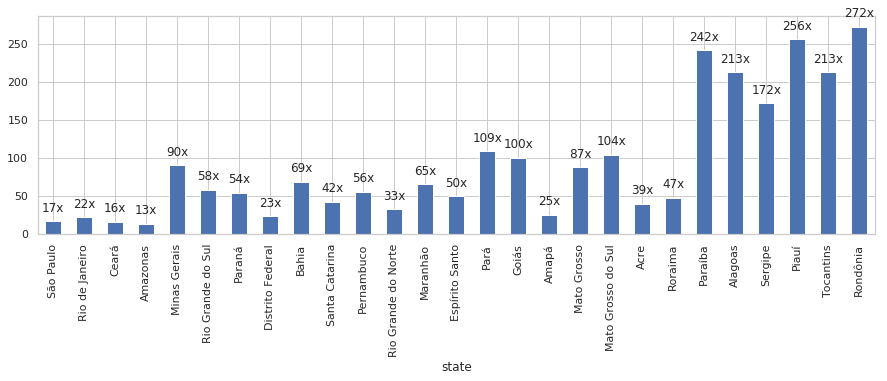

In [210]:
df_tests_cases['multiple'] = df_tests_cases['total_tests'] / df_tests_cases['cases']
df_tests_cases['est_tests'] = df_tests_cases['cases'] / 0.20
df_tests_cases['multiple'].plot(kind='bar', figsize=(15,4))
ys = df_tests_cases['multiple']
xs = range(0,len(ys))
for x,y in zip(xs,ys):
    label = "{:,.0f}x".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.savefig('img/multiple_tests')

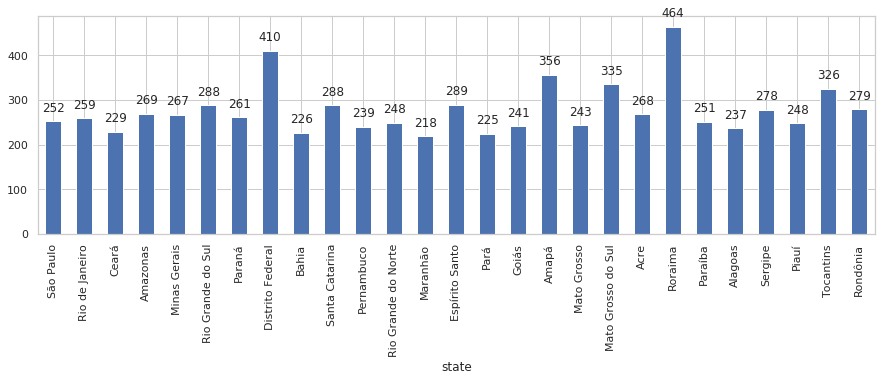

In [211]:
df_tests_cases['tests_100k'] = df_tests_cases['total_tests'] / df_tests_cases['population'] * 100000
df_tests_cases['tests_100k'].plot(kind='bar', figsize=(15,4))
# df_tests_cases
ys = df_tests_cases['tests_100k']
xs = range(0,len(ys))
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.savefig('img/tests_100k')

In [212]:
us_daily_url = 'https://covidtracking.com/api/us/daily.csv'
us_covid = pd.read_csv(us_daily_url)
us_covid['date'] = pd.to_datetime(us_covid['date'], format='%Y%m%d')
print(us_covid['date'].max())
us_covid = us_covid.set_index('date', drop = True)
us_covid = us_covid.sort_values(by = 'date', ascending = True)
us_covid['new_cases'] = us_covid['positive'].diff().fillna(0)
us_data = us_covid.copy()
us_data.loc[str_today]

2020-04-07 00:00:00


KeyError: '2020-04-08'

In [ ]:
plt.figure(figsize = (20,20))

# plt.gca().title('Italian Cases')

plt.subplot('511')
xs = us_data.index.values
ys = us_data['positive']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = us_data['death']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = us_data['death'] / us_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('Positive Rate')
ys = us_data['positive'] / us_data['total'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = us_data['new_cases'] / us_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('./img/us_overview')
plt.show()

In [ ]:
states_daily_url = 'http://covidtracking.com/api/states/daily.csv'
us_covid_state = pd.read_csv(states_daily_url)
us_covid_state['date'] = pd.to_datetime(us_covid_state['date'], format='%Y%m%d')
# us_covid_state = us_covid_state.set_index('date', drop = True)
ny_covid = us_covid_state[us_covid_state['state'] == 'NY']
ny_covid = ny_covid.sort_values(by='date')
ny_covid['new_cases'] = ny_covid['positive'].diff().fillna(0)
ny_data = ny_covid.copy()
# ny_data

In [ ]:
plt.figure(figsize = (20,20))

# plt.gca().title('Italian Cases')

plt.subplot('511')
xs = ny_data['date']
ys = ny_data['positive']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = ny_data['death']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = ny_data['death'] / ny_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('Positive Rate')
ys = ny_data['positive'] / ny_data['total'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = ny_data['new_cases'] / ny_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('./img/ny_overview')
plt.show()

In [ ]:
us_covid_state['rel_date'] = (dt.datetime.now() - pd.to_datetime(us_covid_state['date'])).dt.days
us_covid_state = us_covid_state.set_index('date', drop = True)
us_covid_state['known'] = HDT(us_covid_state['rel_date'])
us_covid_state['known_cases'] = us_covid_state['known'] * us_covid_state['positive']
# us_covid_state

In [ ]:
us_known_cases = us_covid_state.pivot_table(values = 'known_cases', index = 'state', columns = 'date', aggfunc = 'sum').fillna(0).cumsum(axis = 1)
us_deaths = us_covid_state.pivot_table(values = 'death', index = 'state', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
us_deaths = us_deaths[us_deaths[str_today] > 10]
us_death_rate = (us_deaths / us_known_cases * 100).fillna(0)
us_death_rate = us_death_rate[us_death_rate[str_today] > 0]

In [ ]:
us_reported = (3.2 / us_death_rate * 100).replace(np.inf, np.nan)
us_reported = us_reported[us_reported.columns[-4:]].sort_values(by = str_today, ascending = False)
# us_reported

In [ ]:
us_state = us_covid_state[us_covid_state.index == str_today].set_index('state', drop = True)
us_state['positive_rate'] = us_state['positive'] / us_state['total'] * 100
us_state['death_rate'] = us_state['death'] / us_state['positive'] * 100
us_state = us_state.fillna(0)

us_state_data = pd.read_csv('us_states_data.csv')
us_state_data.columns = ['state', 'population','area-miles', 'area']
us_state_data['population'] = us_state_data['population'].str.replace(',','').astype(int)
us_state_data['area-miles'] = us_state_data['area-miles'].str.replace(',','').astype(int)
us_state_data['area'] = us_state_data['area'].str.replace(',','').astype(int)
us_state_data['density'] = us_state_data['population'].astype(float) / us_state_data['area'].astype(float)
us_state_data = us_state_data.set_index('state', drop = True)

us_state = us_state.merge(us_state_data, on='state')
us_state['tests_per_1000'] = us_state['total'] / us_state['population'] * 1000
us_state['positive_per_1000'] = us_state['positive'] / us_state['population'] * 1000

In [ ]:
# us_state.sort_values(by='positive_rate', ascending=False)
df_corr = us_state[['tests_per_1000','positive_per_1000','positive_rate','death_rate','density']].sort_values(by='tests_per_1000', ascending=False).corr()

In [ ]:
plt.figure(figsize = (16,4))
title = 'Correlation Matrix for US States'
# df_result = df_count.div(df_count.sum(axis = 0).sum(), axis = 1) * 100
plt.title(title)
sns.heatmap(df_corr, annot = True, linewidths = 0.5, cmap='Blues', fmt=',.3f')
plt.savefig('./img/' + title)